# 배경 및 목적
* ## 국회 입법활동 중 국회의원 대표발의자 기준으로  같이 활동한 공동발의자를 네트워크 시각화를 통해를 그려보자
* ## 각 의원마다 어떤 소관위관련 법안에 관심이 많고 발의한 법안 처리결과를 살펴봄으로써 각 의원의 입법활동의 투명성을 보여주고자함
+ ## 현 21대 의원은 현재 막 진행하는 국회이기 때문에 제외. 과거데이터 기반으로 한 시각화를 활용하여 추후에 현 국회에 반영 가능

# 목차
## 1. 의원이 발의한 법안 중 대표발의자와 공동발의자의 네트워크 시각화
## 2. 법안처리결과(폐기, 가결, 대안반영)에 따라 각 의원이 발의한 법안이 어떻게 처리됐고 그 법안을 누구와 많이 발의했는지(공동발의)
## 3. 각 의원마다 발의한 전체 법안의 처리결과와 가장 많이 발의한 TOP5 법안 관련 소관위와 소관위별 처리결과 시각화

# 1. 법안 처리와 상관없이 대표발의자마다 누구와 공동발의를 많이 했는지
## 1.1. 데이터 및 라이브러리 로드

In [135]:
library(igraph)
library(networkD3)
library(ggraph)
library(network)
library(sna)
library(tidyverse)
library(scales)
library(plotly)
library(extrafont)
library(reshape2)
library(gridExtra)
library(DT)
loadfonts()

getwd()
setwd('~/sh_R/open')
suggest <- read_csv('open/suggest.csv')

[1] "C:/Users/USER/Documents/sh_R/open"


-- Column specification ------------------------------------------------------------------------------------------------
cols(
  BILL_ID = col_character(),
  BILL_NO = col_double(),
  BILL_NAME = col_character(),
  COMMITTEE = col_character(),
  PROPOSE_DT = col_date(format = ""),
  PROC_RESULT = col_character(),
  AGE = col_double(),
  DETAIL_LINK = col_character(),
  PROPOSER = col_character(),
  MEMBER_LIST = col_character(),
  RST_PROPOSER = col_character(),
  PUBL_PROPOSER = col_character()
)



## 1.2. 데이터 전처리, EDA

### 1.2.1. 20대의원 발의수 TOP5 대표발의자 확인

In [24]:
# 21대의원 대표발의자와 공동발의자 추출
sug_proposer <- suggest %>% 
  filter(AGE == 20) %>%
  group_by(RST_PROPOSER) %>%
  select(RST_PROPOSER, PUBL_PROPOSER)

# 발의 건수 상위 5위 추출
sug_proposer %>%
  group_by(RST_PROPOSER) %>%
  summarise(n = n()) %>%
  arrange(desc(n)) %>% head(5) -> df_index
df_index

`summarise()` ungrouping output (override with `.groups` argument)


RST_PROPOSER,n
황주홍,696
박광온,389
이찬열,324
김도읍,238
박정,228


### 1.2.2 각 대표발의자별로 공동발의자 한명씩 매칭

In [25]:
# 상위 5의 대표발의자와 공동발의자 
top5_proposer <- sug_proposer[sug_proposer$RST_PROPOSER %in% df_index$RST_PROPOSER,]

# 대표발의자와 공동발의자의 관계를 표시하기 위해 하나씩 나열
top5_proposer_split <- data.frame(RST_PROPOSER = top5_proposer$RST_PROPOSER, 
                                   str_split(top5_proposer$PUBL_PROPOSER, ",",  simplify = TRUE))
top5_proposer_split[top5_proposer_split == ""] <- NA

# 각 대표발의자별로 한명씩 공동발의자 매칭
tmp <- data.frame()
test <- data.frame()
for(i in 1:dim(top5_proposer_split)[1]){
  tmp <- data.frame()
  for(j in 2:dim(top5_proposer_split)[2]){
    if(!is.na(top5_proposer_split[i, j])){
      tmp[j-1, 1] = paste0(top5_proposer_split[i, 1], ',', top5_proposer_split[i, j])
    }
  }
  test <- rbind(test, tmp)
}
# saveRDS(test, 'test.rds')
# test <- readRDS('test.rds')

proposer_net <- test
rm(test); rm(tmp)
proposer_from_to <- data.frame(str_split(proposer_net$V1, ",",  simplify = TRUE))
colnames(proposer_from_to) <- c('from','to')
head(proposer_from_to)

from,to
박광온,김병관
박광온,김영주
박광온,김영진
박광온,김종민
박광온,김진표
박광온,송갑석


### 1.2.3. 대표 - 공동발의자별 100건 이상 그래프

`summarise()` regrouping output by 'from' (override with `.groups` argument)


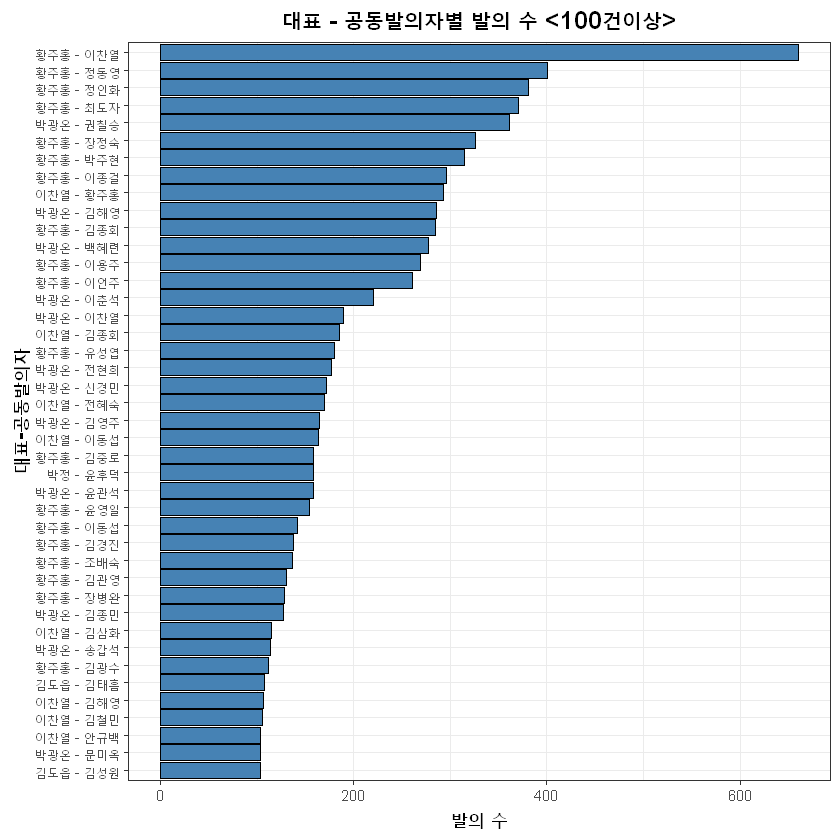

In [27]:
# 대표, 공동발의자별 발의 수
proposer_network <- proposer_from_to %>%
  mutate(from = factor(from)) %>%
  group_by(from, to) %>%
  summarise(n = n()) %>% arrange(desc(n))

proposer_network %>%
    filter(n >= 100) %>%
    ggplot(aes(x = reorder(paste(from, '-', to), n) , y = n)) +
    geom_bar(stat= 'identity', fill='steelblue', color = 'black') +
    coord_flip() +
    theme_bw() +
    ggtitle("대표 - 공동발의자별 발의 수 <100건이상>") +
    labs(x = "대표-공동발의자", y = '발의 수') +
    theme(plot.title = element_text(face = 'bold',hjust = 0.5, size = 15),
          axis.title=element_text(size=13, face ='bold'))

## 1.3. 시각화

### 1.3.1 발의수 상위5위 대표발의자와 공동발의자 전체 네트워크 시각화 (정적)

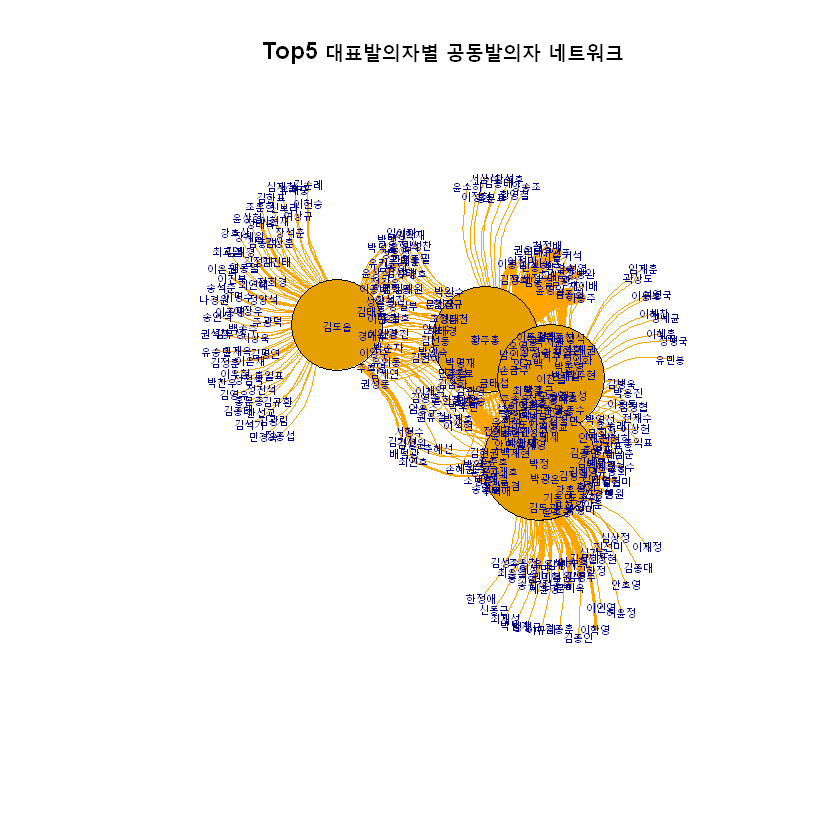

In [32]:
G <- graph_from_data_frame(proposer_network, directed = FALSE);
l = layout_with_fr(G) # layout
plot(G,
     vertex.label.dist=0,
     vertex.shape='circle',
     vertex.size = igraph::degree(G, v =V(G), mode = 'all') / 3, #연결성중심으로 정점 크기
     edge.width = E(G)$n / mean(E(G)$n), #조절할 필요가 있음
     edge.color="orange",
     edge.arrow.size=1,
     edge.curved=.3,
     vertex.label.cex = .5,
     main="Top5 대표발의자별 공동발의자 네트워크",
     layout = l) 

### 정적인 그래프로 나타내게 되면 어떻게 연결되어 있는지 확인하기가 힘듬. 그래서 인터랙티브 그래프를 그리려고함.

### 1.3.2 발의수 상위5위 대표발의자와 공동발의자 전체 네트워크 시각화 (동적)
+ #### (!) Jupyter에 R로 그린 인터랙티브로 표현한 그래프가 나오지 않아 .. 따로 R에서 따로 확인 바랍니다.

In [33]:
 G <- graph_from_data_frame(proposer_network, directed = FALSE)
  
  # 노트 데이터 생성
  nodes <- data.frame(node = (V(G)$name)) 
  size <- data.frame(size = igraph::degree(G, v =V(G), mode = 'all')); rownames(size) <- 1:dim(size)[1]
  nodes <- bind_cols(nodes,size)
  nodes$node <- factor(nodes$node, levels=nodes$node)
  nodes$idx <- 1:dim(nodes)[1]
  
  # 링크 데이터 생성
  links <- data.frame(from = as.numeric(as.factor(proposer_network$from))-1,
                      to = as.numeric(as.factor(proposer_network$to))-1,
                      width = proposer_network$n)
  str(links)
  
  # 시각화
  forceNetwork(Nodes = nodes, Links = links,  Source = 'from', Target = 'to',
               NodeID = 'node', Group = 'node',
               zoom = TRUE, fontSize = 20,
               Nodesize = 'size', # 연결중심성을 기준 사이즈 
               linkDistance = 200, radiusCalculation = JS("d.nodesize+10"),
               Value = 'width', linkWidth = JS("function(d) { return Math.sqrt(d.value) - 3; }"), # 같이 발의한 수에 따른 width
               opacity = 0.6, opacityNoHover = TRUE,
               charge=-900, fontFamily = 'NanuGothic',
               width = 800, height = 600)

'data.frame':	650 obs. of  3 variables:
 $ from : num  4 4 4 4 1 4 4 4 3 1 ...
 $ to   : num  212 238 245 268 15 230 109 208 291 76 ...
 $ width: int  661 401 381 370 361 326 315 296 293 286 ...


HTML widgets cannot be represented in plain text (need html)

### 1.3.3 전체 20대의원중 한명을 뽑아 시각화(정적)

+ #### 위에 살펴본 코드에서  코드를 추가하거나 변경해서 진행.

In [39]:
sug_proposer <- suggest %>% 
    filter(AGE == 20) %>%
    group_by(RST_PROPOSER) %>%
    select(RST_PROPOSER, PUBL_PROPOSER)
  
  # 박재호 의원님의 공동발의자 확인  (추가코드)
  sug_proposer %>%
    filter(RST_PROPOSER == '박광온') -> proposer_tmp
  
    #각 공동발의자를 , 기준으로 나눔
  proposer_tmp_split <- data.frame(RST_PROPOSER = proposer_tmp$RST_PROPOSER, 
                                     str_split(proposer_tmp$PUBL_PROPOSER, ",",  simplify = TRUE))
  proposer_tmp_split[proposer_tmp_split == ""] <- NA
  # top10_proposer_split %>%
  #   group_by(RST_PROPOSER) %>%
  #   summarise(n = n()) %>% arrange(desc(n))
    
  # 대표발의자를 기준으로 한명씩 공동발의자를 연결
  tmp <- data.frame()
  test <- data.frame()
  for(i in 1:dim(proposer_tmp_split)[1]){
    tmp <- data.frame()
    for(j in 2:dim(proposer_tmp_split)[2]){
      if(!is.na(proposer_tmp_split[i, j])){
        tmp[j-1, 1] = paste0(proposer_tmp_split[i, 1], ',', proposer_tmp_split[i, j])
      }
    }
    test <- rbind(test, tmp)
  }
    
  RST_proposer <- test
  rm(test); rm(tmp)
    
  RST_proposer <- data.frame(str_split(RST_proposer$V1, ",",  simplify = TRUE))
  colnames(RST_proposer) <- c('from','to')
  
  # 각 대표발의자, 공동발의자별로 대표발의자와 각 공동발의자가 얼마나 많은 발의를 했는지 카운트
  RST_proposer %>%
    mutate(from = factor(from)) %>%
    group_by(from, to) %>%
    summarise(n = n()) %>% 
    arrange(desc(n)) -> RST_proposer_network

`summarise()` regrouping output by 'from' (override with `.groups` argument)


+ #### 여기까지 살짝 코드를 변경하고 추가 했습니다.

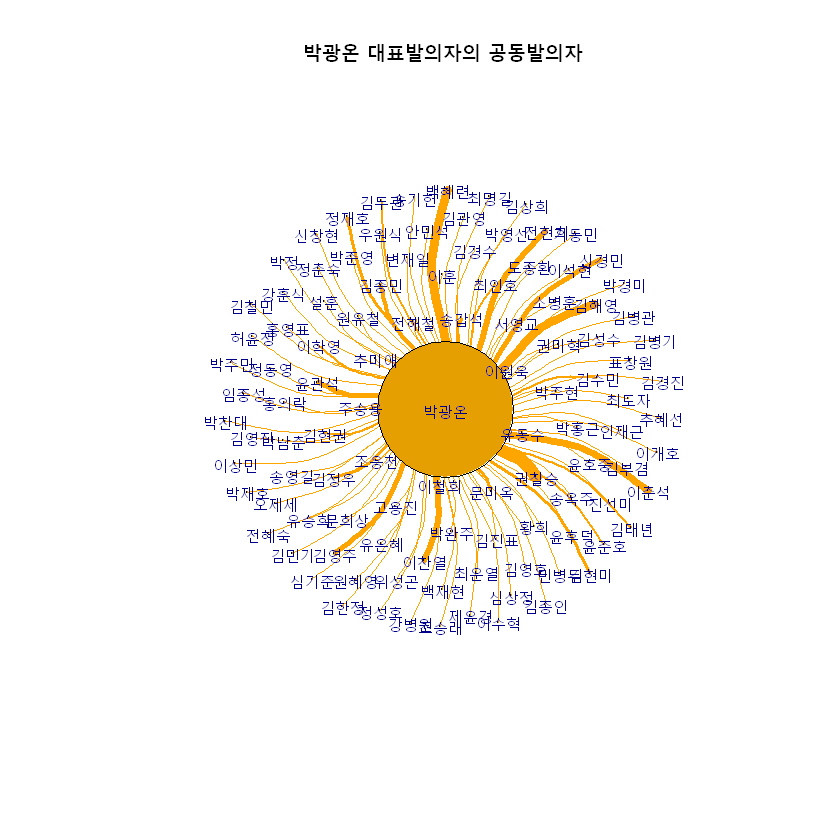

In [40]:
  # 네트워크 시각화
  G <- graph_from_data_frame(RST_proposer_network, directed = FALSE);
  # G <- igraph::delete_edges(G, E(G)[[n >= 10]]) # n번이상 공동발의한 사람만
    
  #l <- layout.fruchterman.reingold(G)
  #l <- layout.kamada.kawai(G)
  l = layout_with_fr(G)
    
  plot(G,
       vertex.label.dist=0,
       vertex.shape='circle',
       vertex.size = igraph::degree(G, v =V(G), mode = 'all') / 1.7, #연결중심성
       edge.width = E(G)$n / mean(E(G)$n), # 조절
       edge.color="orange",
       edge.arrow.size=1,
       edge.curved=.3, #커브정도, 안해두됨
       vertex.label.cex = 1,
       main='박광온 대표발의자의 공동발의자',
       layout = l)

+ #### 마찬가지로 인터랙티브하게 시각화를 진행

### 1.3.4 전체 20대의원중 한명을 뽑아 시각화(동적)
+ #### 위에 살펴본 코드에서  코드를 추가하거나 변경해서 진행.

In [38]:
G <- graph_from_data_frame(RST_proposer_network, directed = FALSE);
nodes <- data.frame(node = (V(G)$name)) 
  size <- data.frame(size = igraph::degree(G, v =V(G), mode = 'all')); rownames(size) <- 1:dim(size)[1]
  nodes <- bind_cols(nodes,size)
  nodes$node <- factor(nodes$node, levels=nodes$node)
  nodes$idx <- 1:dim(nodes)[1]
  
  # 링크 데이터 생성
  links <- data.frame(from = as.numeric(as.factor(RST_proposer_network$from))-1,
                      to = as.numeric(as.factor(RST_proposer_network$to))-1,
                      width = RST_proposer_network$n)
  str(links)
  
  # 동적 네트워크 시각화
  forceNetwork(Nodes = nodes, Links = links,  Source = 'from', Target = 'to',
               NodeID = 'node', Group = 'node',
               zoom = TRUE, fontSize = 20,
               Nodesize = 'size',
               linkDistance = 200, radiusCalculation = JS("d.nodesize+10"),
               linkColour = c("gray"),
               Value = 'width', linkWidth = JS("function(d) { return Math.sqrt(d.value) - 4; }"),
               opacity = 0.6, opacityNoHover = TRUE,
               charge=-900, fontFamily = 'NanuGothic')

'data.frame':	107 obs. of  3 variables:
 $ from : num  0 0 0 0 0 0 0 0 0 0 ...
 $ to   : num  4 27 46 79 77 85 55 17 68 21 ...
 $ width: int  361 286 277 220 189 177 172 164 158 127 ...


HTML widgets cannot be represented in plain text (need html)

## 1.4. 함수화
+ ### 위에 코드를 입력한 n대의원, 이름을 받아 재사용할 수 있게 함수화 시켰습니다.
+ ### 함수화는 3D네트워크 시각화만 진행했으므로 R사용자는 따로 돌려보시기 바랍니다.

### 1.4.1. n대의원 발의수 Top5의 대표발의자와 그에 따른 공동발의자 네트워크 시각화
+ #### TOP5의 네트워크 그래프는 인터랙티브 그래프로 그려야 구분하기가 쉬워서 정적그래프는 뺌.

In [233]:
proposer_top5 <- function(age){
  sug_proposer <- suggest %>% 
    filter(AGE == age) %>%
    group_by(RST_PROPOSER) %>%
    select(RST_PROPOSER, PUBL_PROPOSER)
  
  # 발의 건수 상위 10위 추출
  sug_proposer %>%
    group_by(RST_PROPOSER) %>%
    summarise(n = n()) %>%
    arrange(desc(n)) %>% head(5) -> df_index
  
  # 상위 10명의 대표발의자와 공동발의자 
  top5_proposer <- sug_proposer[sug_proposer$RST_PROPOSER %in% df_index$RST_PROPOSER,]
  top5_proposer %>%
    group_by(RST_PROPOSER) %>%
    summarise(n = n()) %>% arrange(desc(n))
  
  # 대표발의자와 공동발의자의 관계를 표시하기 위해 하나씩 나열
  top5_proposer_split <- data.frame(RST_PROPOSER = top5_proposer$RST_PROPOSER, 
                                     str_split(top5_proposer$PUBL_PROPOSER, ",",  simplify = TRUE))
  top5_proposer_split[top5_proposer_split == ""] <- NA
  # top10_proposer_split %>%
  #   group_by(RST_PROPOSER) %>%
  #   summarise(n = n()) %>% arrange(desc(n))
  
  test <- data.frame()
  for(i in 1:dim(top5_proposer_split)[1]){
    tmp <- data.frame()
    for(j in 2:dim(top5_proposer_split)[2]){
      if(!is.na(top5_proposer_split[i, j])){
        tmp[j-1, 1] = paste0(top5_proposer_split[i, 1], ',', top5_proposer_split[i, j])
      }
    }
    test <- rbind(test, tmp)
  }
  
  proposer_net <- test
  rm(test); rm(tmp)
  proposer_from_to <- data.frame(str_split(proposer_net$V1, ",",  simplify = TRUE))
  colnames(proposer_from_to) <- c('from','to')
  
  # 대표, 공동발의자별 발의 수
  proposer_from_to %>%
    group_by(from, to) %>%
    summarise(n = n()) %>% arrange(desc(n))

  # 각 대표발의자의 관계 수
  proposer_from_to %>%
    mutate(from = factor(from)) %>%
    group_by(from) %>%
    summarise(n = n()) %>% arrange(desc(n)) %>%
    ggplot(aes(x = from, y = n)) +
    geom_bar(stat='identity')
  
  # 대표, 공동발의자별 발의 수
  proposer_network <- proposer_from_to %>%
    mutate(from = factor(from)) %>%
    group_by(from, to) %>%
    summarise(n = n()) %>% arrange(desc(n))
  
  # 데이터 프레임을 igraph로 변경
  G <- graph_from_data_frame(proposer_network, directed = FALSE)
  
  # 노트 데이터 생성
  nodes <- data.frame(node = (V(G)$name)) 
  size <- data.frame(size = igraph::degree(G, v =V(G), mode = 'all')); rownames(size) <- 1:dim(size)[1]
  nodes <- bind_cols(nodes,size)
  nodes$node <- factor(nodes$node, levels=nodes$node)
  nodes$idx <- 1:dim(nodes)[1]
  
  # 링크 데이터 생성
  links <- data.frame(from = as.numeric(as.factor(proposer_network$from))-1,
                      to = as.numeric(as.factor(proposer_network$to))-1,
                      width = proposer_network$n)
  str(links)
  
  # 시각화
  forceNetwork(Nodes = nodes, Links = links,  Source = 'from', Target = 'to',
               NodeID = 'node', Group = 'node',
               zoom = TRUE, fontSize = 20,
               Nodesize = 'size', # 연결중심성을 기준 사이즈 
               linkDistance = 200, radiusCalculation = JS("d.nodesize+10"),
               Value = 'width', linkWidth = JS("function(d) { return Math.sqrt(d.value) - 3; }"), # 같이 발의한 수에 따른 width
               opacity = 0.6, opacityNoHover = TRUE,
               charge=-900, fontFamily = 'NanuGothic',
               width = 800, height = 600) -> plot
  
  return(plot)
}

In [234]:
proposer_top5('20') # n대의원

`summarise()` ungrouping output (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)
`summarise()` regrouping output by 'from' (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)
`summarise()` regrouping output by 'from' (override with `.groups` argument)


'data.frame':	650 obs. of  3 variables:
 $ from : num  4 4 4 4 1 4 4 4 3 1 ...
 $ to   : num  212 238 245 268 15 230 109 208 291 76 ...
 $ width: int  661 401 381 370 361 326 315 296 293 286 ...


HTML widgets cannot be represented in plain text (need html)

### 1.4.2. 대표-공동 발의자별 발의 수 그래프(Bar)

In [235]:
suggest_network_count <- function(age, name){
  # 20대의원 대표발의자와 공동발의자 추출
  sug_proposer <- suggest %>% 
    filter(AGE == 20) %>%
    group_by(RST_PROPOSER) %>%
    select(RST_PROPOSER, PUBL_PROPOSER)
  
  # 찾고 있는 대표발의자 인수
  sug_proposer %>%
    filter(RST_PROPOSER == name) -> proposer_tmp
  
  # 공동발의자를 한명씩 분리
  proposer_tmp_split <- data.frame(RST_PROPOSER = proposer_tmp$RST_PROPOSER, 
                                   str_split(proposer_tmp$PUBL_PROPOSER, ",",  simplify = TRUE))
  proposer_tmp_split[proposer_tmp_split == ""] <- NA
  # top10_proposer_split %>%
  #   group_by(RST_PROPOSER) %>%
  #   summarise(n = n()) %>% arrange(desc(n))
  
  tmp <- data.frame()
  test <- data.frame()
  for(i in 1:dim(proposer_tmp_split)[1]){
    tmp <- data.frame()
    for(j in 2:dim(proposer_tmp_split)[2]){
      if(!is.na(proposer_tmp_split[i, j])){
        tmp[j-1, 1] = paste0(proposer_tmp_split[i, 1], ',', proposer_tmp_split[i, j])
      }
    }
    test <- rbind(test, tmp)
  }
  RST_proposer <- test
  rm(test); rm(tmp)
  RST_proposer <- data.frame(str_split(RST_proposer$V1, ",",  simplify = TRUE))
  colnames(RST_proposer) <- c('from','to')
  
  RST_proposer %>%
    mutate(from = factor(from)) %>%
    group_by(from, to) %>%
    summarise(n = n()) %>% 
    arrange(desc(n)) -> RST_proposer_network
  
    # 대표발의자 기준 5번이상 공동발의한 사람
  RST_proposer_network %>%
    filter(n >= 100) %>%
    ggplot(aes(x = reorder(paste(from, '-', to), n) , y = n)) +
    geom_bar(stat= 'identity', fill='steelblue', color = 'black') +
    coord_flip() +
    theme_bw() +
    ylab('발의수') +
    xlab('대표-공동') +
    ggtitle(paste0(age,'대'," ",name,' 대표발의자의 공동발의자 <100건이상>')) +
    theme(axis.title=element_text(size=13, face ='bold'),
          plot.title=element_text(size =15, hjust = 0.5, face = 'bold'))
}

In [236]:
# suggest_network_count(20, '박광온')

### 1.4.3. 대표-공동 발의자별 발의 수 그래프(Network)

+ #### 각 대표발의자를 기준으로 가장 많이 연결된 대표발의자별로 노드 크기, 공동발의자와 같이한 발의 수에 따른 링크 굵기를 설정

+ #### 인터랙티브 그래프

In [72]:
suggest_network <- function(age, name) {
    
  # 21대의원 대표발의자와 공동발의자 추출
  sug_proposer <- suggest %>% 
    filter(AGE == age) %>%
    group_by(RST_PROPOSER) %>%
    select(RST_PROPOSER, PUBL_PROPOSER)
  
  sug_proposer %>%
    filter(RST_PROPOSER == name) -> proposer_tmp
  
    #각 공동발의자를 , 기준으로 나눔
  proposer_tmp_split <- data.frame(RST_PROPOSER = proposer_tmp$RST_PROPOSER, 
                                     str_split(proposer_tmp$PUBL_PROPOSER, ",",  simplify = TRUE))
  proposer_tmp_split[proposer_tmp_split == ""] <- NA
  # top10_proposer_split %>%
  #   group_by(RST_PROPOSER) %>%
  #   summarise(n = n()) %>% arrange(desc(n))
    
  # 대표발의자를 기준으로 한명씩 공동발의자를 연결
  tmp <- data.frame()
  test <- data.frame()
  for(i in 1:dim(proposer_tmp_split)[1]){
    tmp <- data.frame()
    for(j in 2:dim(proposer_tmp_split)[2]){
      if(!is.na(proposer_tmp_split[i, j])){
        tmp[j-1, 1] = paste0(proposer_tmp_split[i, 1], ',', proposer_tmp_split[i, j])
      }
    }
    test <- rbind(test, tmp)
  }
    
  RST_proposer <- test
  rm(test); rm(tmp)
    
  RST_proposer <- data.frame(str_split(RST_proposer$V1, ",",  simplify = TRUE))
  colnames(RST_proposer) <- c('from','to')
  
  # 각 대표발의자, 공동발의자별로 대표발의자와 각 공동발의자가 얼마나 많은 발의를 했는지 카운트
  RST_proposer %>%
    mutate(from = factor(from)) %>%
    group_by(from, to) %>%
    summarise(n = n()) %>% 
    arrange(desc(n)) -> RST_proposer_network
  
  # 네트워크 시각화
  G <- graph_from_data_frame(RST_proposer_network, directed = FALSE);
  # G <- igraph::delete_edges(G, E(G)[[n >= 10]]) # n번이상 공동발의한 사람만
    
  #l <- layout.fruchterman.reingold(G)
  #l <- layout.kamada.kawai(G)
  l = layout_with_fr(G)

  nodes <- data.frame(node = (V(G)$name)) 
  size <- data.frame(size = igraph::degree(G, v =V(G), mode = 'all')); rownames(size) <- 1:dim(size)[1]
  nodes <- bind_cols(nodes,size)
  nodes$node <- factor(nodes$node, levels=nodes$node)
  nodes$idx <- 1:dim(nodes)[1]
  
  # 링크 데이터 생성
  links <- data.frame(from = as.numeric(as.factor(RST_proposer_network$from))-1,
                      to = as.numeric(as.factor(RST_proposer_network$to))-1,
                      width = RST_proposer_network$n)
  str(links)
  
  # 동적 네트워크 시각화
  forceNetwork(Nodes = nodes, Links = links,  Source = 'from', Target = 'to',
               NodeID = 'node', Group = 'node',
               zoom = TRUE, fontSize = 20,
               Nodesize = 'size',
               linkDistance = 200, radiusCalculation = JS("d.nodesize+10"),
               linkColour = c("gray"),
               Value = 'width', linkWidth = JS("function(d) { return Math.sqrt(d.value) - 4; }"),
               opacity = 0.6, opacityNoHover = TRUE,
               charge=-900, fontFamily = 'NanuGothic',
               width = 800, height = ) -> plot
  
  
  return(plot)
}

In [73]:
suggest_network(20, '박광온') # 21대의원 이름 넣기

`summarise()` regrouping output by 'from' (override with `.groups` argument)


'data.frame':	107 obs. of  3 variables:
 $ from : num  0 0 0 0 0 0 0 0 0 0 ...
 $ to   : num  4 27 46 79 77 85 55 17 68 21 ...
 $ width: int  361 286 277 220 189 177 172 164 158 127 ...


HTML widgets cannot be represented in plain text (need html)

# 2. 법안처리결과(폐기, 가결, 대안반영)에 따라 각 의원이 발의한 법안이 어떻게 처리됐고 그 법안을 누구와 많이 발의했는지(공동발의)
* ## 20대의원 중 어떤의원이 가결, 폐기, 대안반영이 많은가?

## 2.1. 법안발의한 역대 의원 결과 비교(현 21대의원 제외)

`summarise()` regrouping output by 'AGE' (override with `.groups` argument)


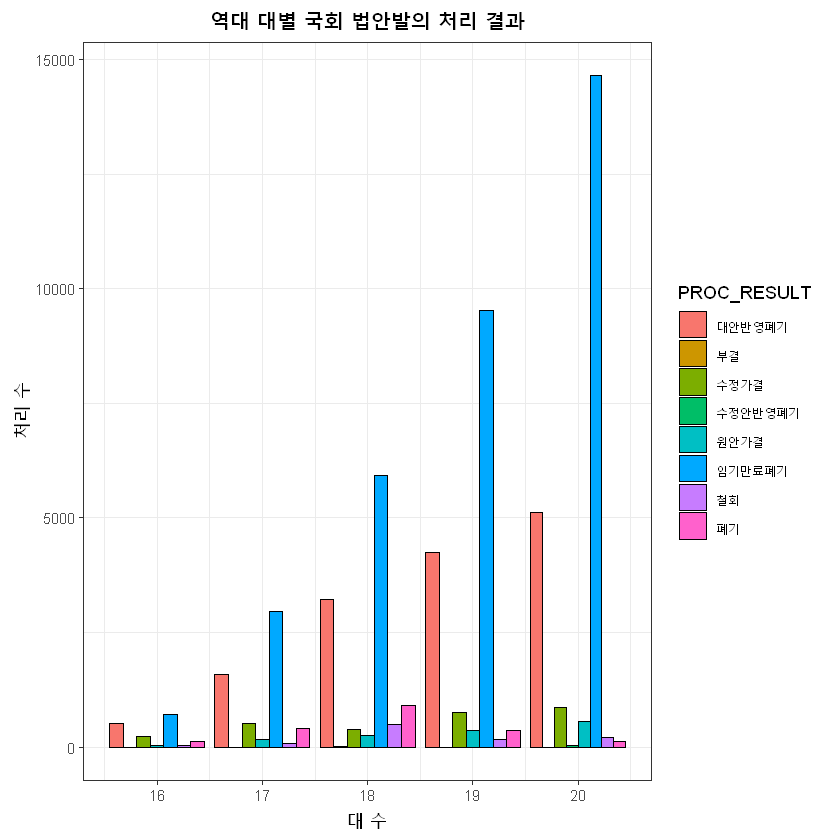

In [87]:
suggest %>%
  filter(AGE >= 16 & AGE != 21) %>%
  group_by(AGE, PROC_RESULT) %>%
  summarise(n = n()) %>% 
  arrange(desc(n)) %>%
  ggplot(aes(x = AGE, y = n, color = PROC_RESULT, fill = PROC_RESULT)) +
  geom_bar(stat = 'identity', position = 'dodge', color = 'black') +
  theme_bw() +
  ggtitle("역대 대별 국회 법안발의 처리 결과") +
  labs(x = "대 수", y = "처리 수") +
  theme(plot.title = element_text(size = 15, hjust = 0.5, face = 'bold'),
        axis.title = element_text(size = 13, face = 'bold'))

+ #### 전체적으로 시간에 지남에 따라 각 처리결과들이 증가

## 2.2. 2000년도 21세기(16대)~ 20대까지 폐기, 가결, 대안반영만 따로 보기로 하자

+ ### 21대는 진행중인 국회이므로 제외

`summarise()` regrouping output by 'AGE' (override with `.groups` argument)


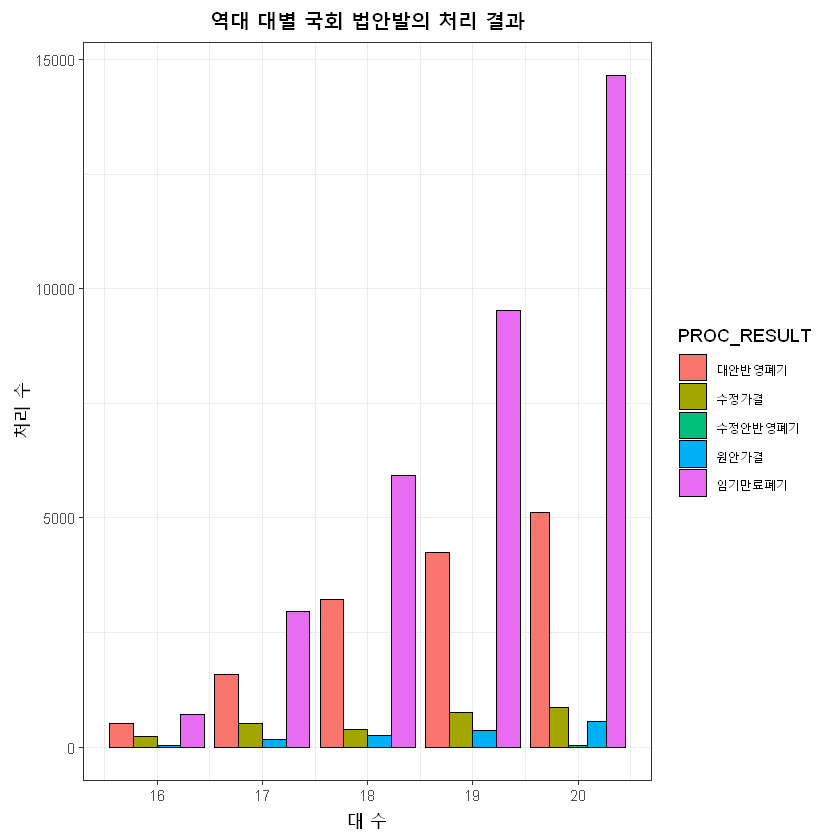

In [91]:
suggest %>%
  filter(AGE >= 16 & AGE != 21) %>%
  filter(PROC_RESULT == '임기만료폐기'|PROC_RESULT == '수정안반영폐기' | 
           PROC_RESULT == '수정가결' | PROC_RESULT == '원안가결' | PROC_RESULT == '대안반영폐기') %>%
  group_by(AGE, PROC_RESULT) %>%
  summarise(n = n()) %>% 
  arrange(desc(n)) %>%
  ggplot(aes(x = AGE, y = n, color = PROC_RESULT, fill = PROC_RESULT)) +
  geom_bar(stat = 'identity', position = 'dodge', color = 'black') + 
  theme_bw() +
  ggtitle("역대 대별 국회 법안발의 처리 결과") +
  labs(x = "대 수", y = "처리 수") +
  theme(plot.title = element_text(size = 15, hjust = 0.5, face = 'bold'),
        axis.title = element_text(size = 13, face = 'bold'))

## 2.3. 16~20대의원, 각 대별 전체 발의수

`summarise()` ungrouping output (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)


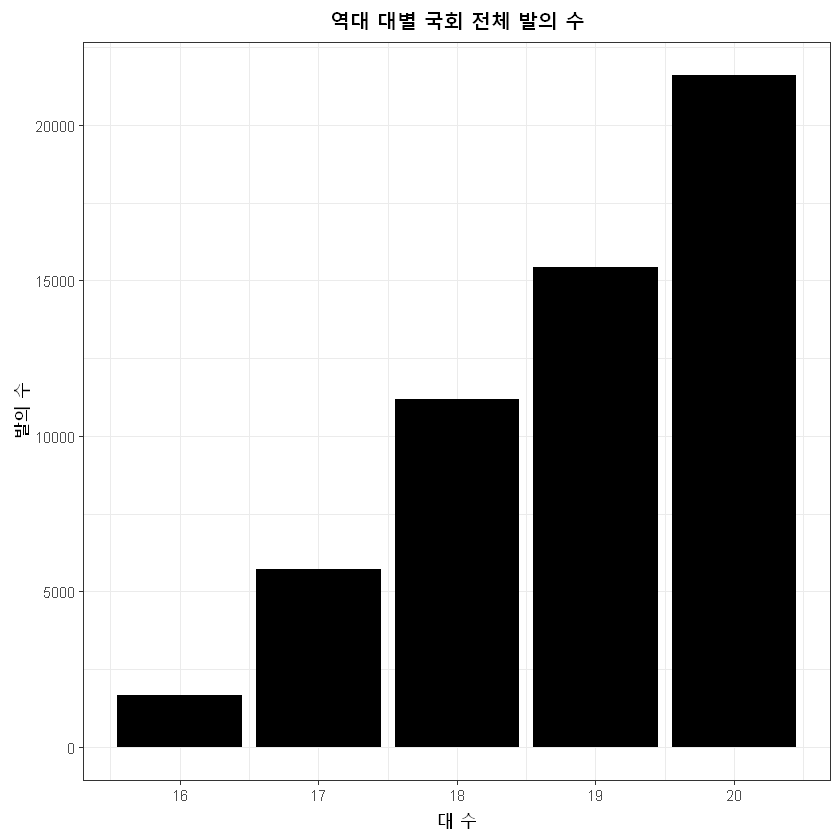

In [101]:
suggest %>%
  filter(AGE >= 16 & AGE != 21) %>%
  group_by(AGE) %>%
  summarise(발의수 = n()) %>%
  ggplot(aes(x = AGE, y = 발의수)) +
  geom_bar(stat = 'identity', fill = 'black') +
  theme_bw() +
  ggtitle("역대 대별 국회 전체 발의 수") +
  labs(x = "대 수", y = "발의 수") +
  theme(plot.title = element_text(size = 15, hjust = 0.5, face = 'bold'),
        axis.title = element_text(size = 13, face = 'bold'))

### 각 대별로 전체 법안발의수 데이터 추출
suggest  %>%
  filter(AGE >= 16, AGE != 21) %>%
  group_by(AGE) %>%
  summarise(법안발의수 = n()) -> age_total

+ ### 해석: 시간이 지남에 따라 발의 수가 증가 -> 입법활동이 점점 활발해 지고 있음

## 2.4. 폐기수 및 폐기율(수정안반영폐기, 임기만료폐기) 

In [102]:
### 폐기관련 처리만 추출
suggest %>%
  filter(AGE >= 16, AGE != 21) %>%
  filter(PROC_RESULT == '임기만료폐기'|PROC_RESULT == '수정안반영폐기') %>%
  group_by(AGE) %>%
  summarise(폐기수 = n()) -> age_trash_total

trash_df <- inner_join(age_total, age_trash_total, by = 'AGE') # 대 기준으로 조인

`summarise()` ungrouping output (override with `.groups` argument)


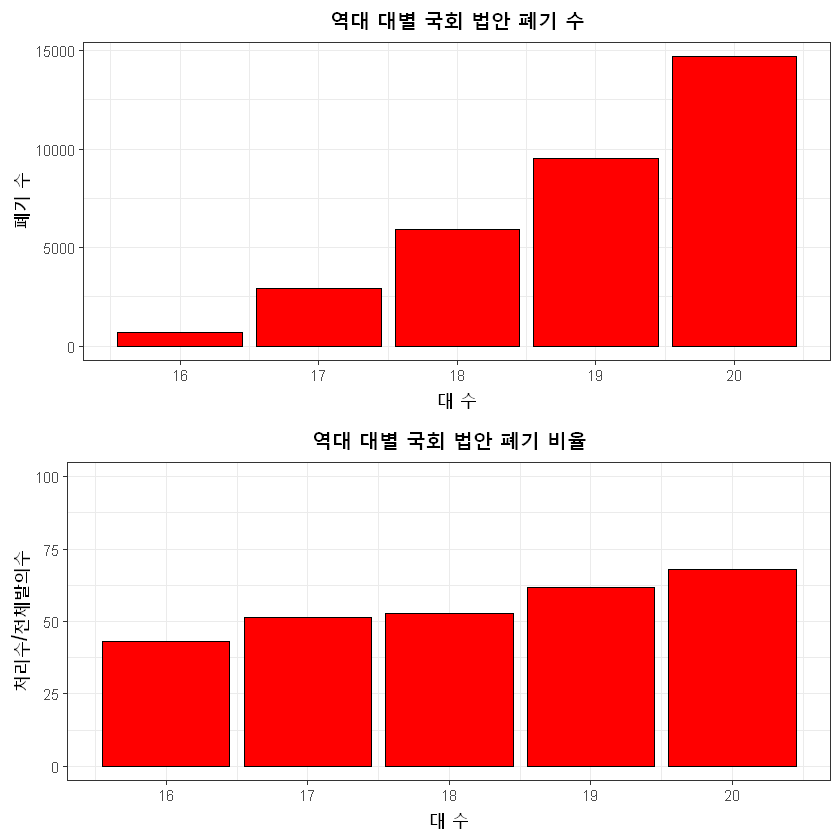

In [113]:
#### 대별 폐기수
trash_df %>%
  ggplot(aes(x = AGE, y = 폐기수)) +
  geom_bar(stat='identity', fill = 'red', color = 'black') +
  theme_bw() +
  ggtitle("역대 대별 국회 법안 폐기 수") +
  labs(x = "대 수", y = "폐기 수") +
  theme(plot.title = element_text(size = 15, hjust = 0.5, face = 'bold'),
        axis.title = element_text(size = 13, face = 'bold')) -> p1

#### 대별 폐기 비율
trash_df %>%
  mutate(폐기_비율 = (폐기수 / 법안발의수) *100) %>%
  ggplot(aes(x = AGE, y = 폐기_비율)) +
  geom_bar(stat = 'identity', fill = 'red', color = 'black') +
  ylim(c(0,100)) +
  theme_bw() +
  ggtitle("역대 대별 국회 법안 폐기 비율") +
  labs(x = "대 수", y = "처리수/전체발의수") +
  theme(plot.title = element_text(size = 15, hjust = 0.5, face = 'bold'),
        axis.title = element_text(size = 13, face = 'bold'))-> p2

grid.arrange(p1,p2)

+ ### 해석: 각 대별로 폐기비율 = 폐기수 / 발의수 
+ ### 점점 폐기율이 높아지므로 발의수 대비 폐기수가 점점해 폐기가 되는 법안이 상당히 많음

## 2.5. 가결수 및 가결율

In [110]:
#### 수정가결과 원안가별을 합친 수를 구함
suggest %>%
  filter(AGE >= 16, AGE != 21) %>%
  filter(PROC_RESULT == '수정가결' | PROC_RESULT == '원안가결') %>%
  group_by(AGE) %>%
  summarise(가결수 = n()) -> age_success_total 

`summarise()` ungrouping output (override with `.groups` argument)


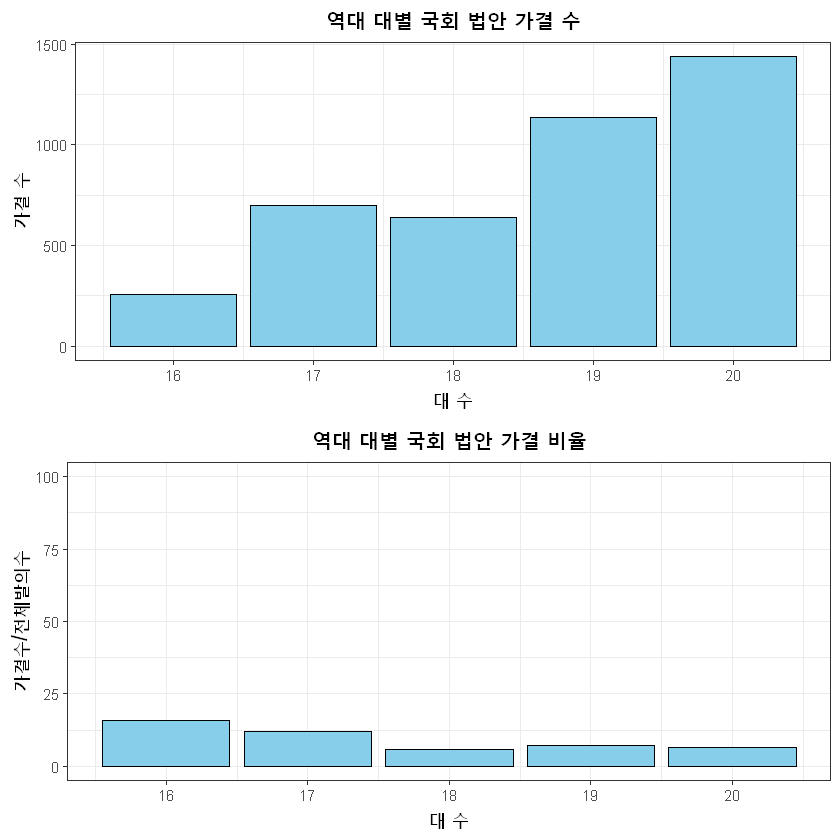

In [115]:
#### 대별 가결수(수정+원안)
success_df <- inner_join(age_total, age_success_total, by = 'AGE')
success_df %>%
  ggplot(aes(x = AGE, y = 가결수)) +
  geom_bar(stat='identity', fill = 'skyblue', color = 'black') +
  theme_bw() +
  ggtitle("역대 대별 국회 법안 가결 수") +
  labs(x = "대 수", y = "가결 수") +
  theme(plot.title = element_text(size = 15, hjust = 0.5, face = 'bold'),
        axis.title = element_text(size = 13, face = 'bold')) -> p1

#### 대별 가결율(수정+원안)
success_df %>%
  mutate(가결_비율 = (가결수 / 법안발의수) *100) %>%
  ggplot(aes(x = AGE, y = 가결_비율)) +
  geom_bar(stat = 'identity', fill = 'skyblue', color = 'black') +
  ylim(c(0,100)) +
  theme_bw() +
  ggtitle("역대 대별 국회 법안 가결 비율") +
  labs(x = "대 수", y = "가결수/전체발의수") +
  theme(plot.title = element_text(size = 15, hjust = 0.5, face = 'bold'),
        axis.title = element_text(size = 13, face = 'bold'))-> p2

grid.arrange(p1,p2)

+ ### 해석: 가결도 16년에는 조금 멈추는듯하나 전체 발의 증가 추세에 맞게 가결수도 증가 -> 발의한 법안 만큼 가결되는 법안도 증가, 가결수는 증가하고 있으나 전체발의건수대비 가결비율은 낮아지는 추세이다. 가결수는 증가하고있지만 가결율이 낮아 가결되는 법안은 극히 적음

## 2.6. 대안반영 및 대안반영율

`summarise()` ungrouping output (override with `.groups` argument)


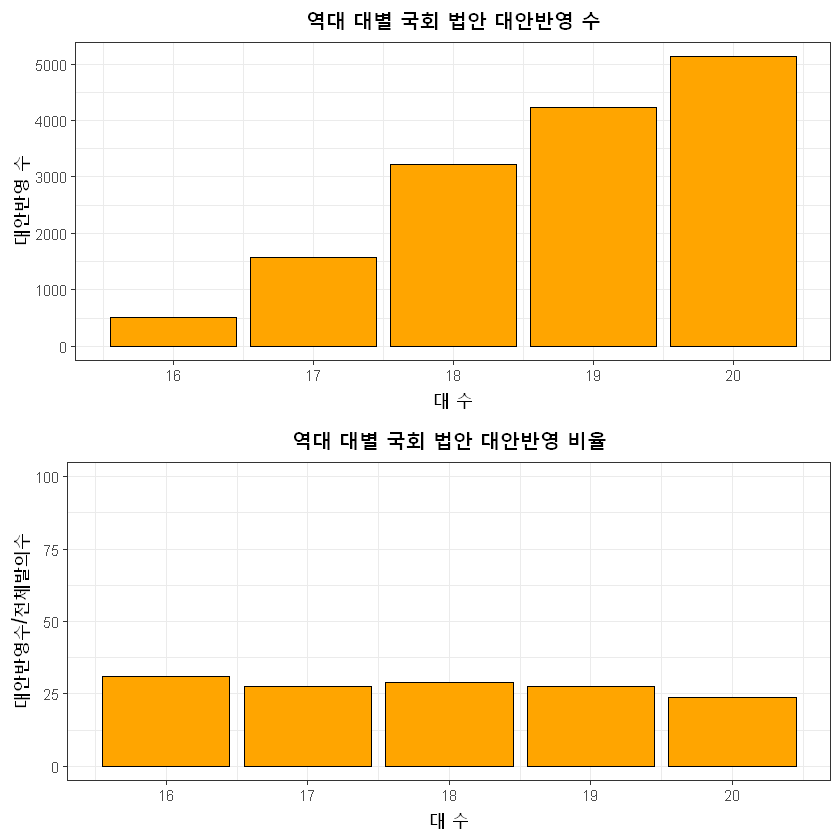

In [116]:
### 대안반영은 폐기가 아니라 이미 비슷한 법이나 대체할 수 있는 법이 있으므로 그 법으로 수정,추가하여 대체하는 것이므로 폐기와 따로 분리
suggest %>%
  filter(AGE >= 16, AGE != 21) %>%
  filter(PROC_RESULT == '대안반영폐기') %>%
  group_by(AGE) %>%
  summarise(대안반영수 = n()) -> age_alter_total 

alter_df <- inner_join(age_total, age_alter_total, by = 'AGE')
#### 대안반영수
alter_df %>%
  ggplot(aes(x = AGE, y = 대안반영수)) +
  geom_bar(stat='identity', fill = 'orange', color = 'black') +
  theme_bw() +
  ggtitle("역대 대별 국회 법안 대안반영 수") +
  labs(x = "대 수", y = "대안반영 수") +
  theme(plot.title = element_text(size = 15, hjust = 0.5, face = 'bold'),
        axis.title = element_text(size = 13, face = 'bold')) -> p1

### 대안반영율
alter_df %>%
  mutate(대안반영_비율 = (대안반영수 / 법안발의수) *100) %>%
  ggplot(aes(x = AGE, y = 대안반영_비율)) +
  geom_bar(stat = 'identity', fill ='orange', color = 'black') +
  ylim(c(0,100)) + 
  theme_bw() +
  ggtitle("역대 대별 국회 법안 대안반영 비율") +
  labs(x = "대 수", y = "대안반영수/전체발의수") +
  theme(plot.title = element_text(size = 15, hjust = 0.5, face = 'bold'),
        axis.title = element_text(size = 13, face = 'bold'))-> p2

grid.arrange(p1,p2)

+ ### 해석: 가결비율과 마찬가지로 대안반영수는 증가하지만 전체대비 비율은 낮아지고있다. 대안반영은 발의된 법안이 이미 있는 법안에 속한 것이 있어서 그법안으로 대체하고 폐기하는 것이다. 정확히는 폐기라고는 할 수 없다. 의원들이 중복되는 법안을 제시해서 일당을 채우려는 것은 잘못된 것이며, 대안반영이 적을 수 록 국회가 더 효율적으로 움직일 수 있을 것 같다.

## 2.7. 각 법안처리결과 조인후 테이블

In [127]:
df <- inner_join(trash_df, success_df, by = c('AGE', '법안발의수'))
age_df <- inner_join(df, alter_df,  by = c('AGE', '법안발의수'))
age_df %>%
  mutate(폐기율 = round(폐기수 / 법안발의수,3),
            가결율 = round(가결수 / 법안발의수,3),
            대안반영율 = round(대안반영수 / 법안발의수,3)) -> age_df
datatable(age_df)

HTML widgets cannot be represented in plain text (need html)

## 2.8 각 폐기, 가결, 대안반영수 및 비율 비교

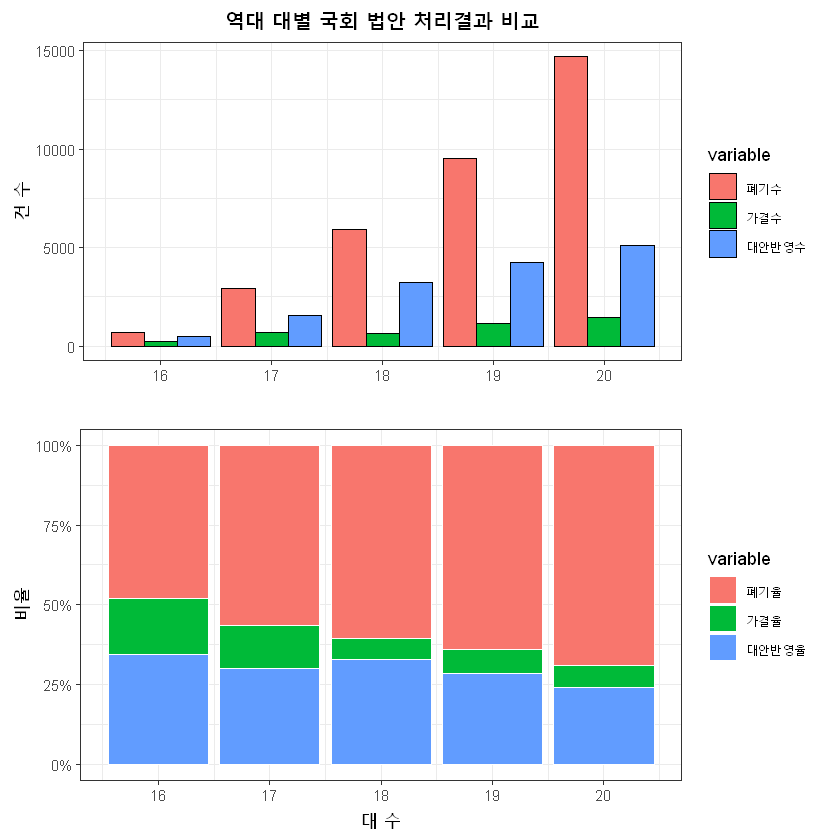

In [151]:
# 폐기수, 가결수, 대안반영수
library(reshape2)
melt_age_df2 <- melt(age_df, id.vars = 'AGE', measure.vars = c('폐기수','가결수','대안반영수'))
melt_age_df2 %>%
  ggplot(aes(x = AGE, y =value, fill = variable)) +
  geom_bar(stat='identity', positio = 'dodge', color = 'black') +
  theme_bw() +
  ggtitle("역대 대별 국회 법안 처리결과 비교") +
  labs(x = "", y = "건 수") +
  theme(plot.title = element_text(size = 15, hjust = 0.5, face = 'bold'),
        axis.title = element_text(size = 13, face = 'bold'))-> p1

melt_age_df <- melt(age_df, id.vars = 'AGE', measure.vars = c('폐기율','가결율','대안반영율'))
melt_age_df %>%
  ggplot(aes(x = AGE, y = value, fill = variable)) +
  geom_bar(stat='identity', position = 'fill', color = 'white') +
  theme_bw() +
  labs(x = "대 수", y = "비율") +
  theme(axis.title = element_text(size = 13, face = 'bold')) +
  scale_y_continuous(labels = percent) -> p2

grid.arrange(p1,p2)

## 2.7. 20대의원 중 어떤 의원이 폐기, 가결, 대안반영을 많이 했는지, 그 대표의원과 공동발의 의원을 네트워크 시각화

### 2.7.1 전체 발의중 20대의원의 발의만 추출

`summarise()` ungrouping output (override with `.groups` argument)


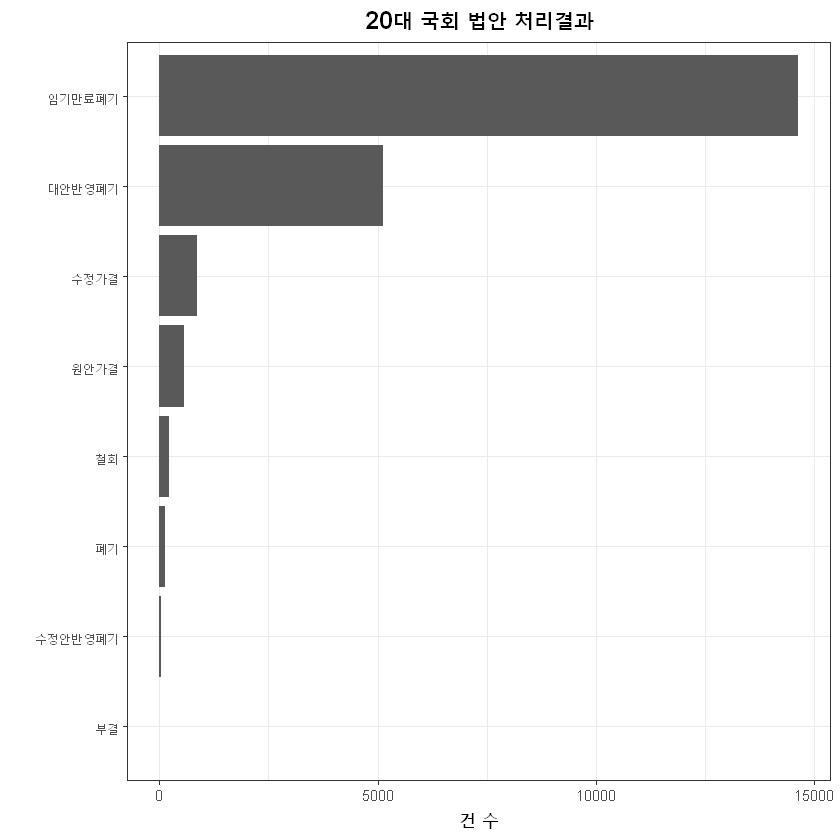

In [156]:
suggest %>%
  filter(AGE == 20) -> suggest_age20

### 20대의원 법안처리결과
suggest_age20 %>%
  group_by(PROC_RESULT) %>%
  summarise(n = n()) %>% 
  ggplot(aes(x = reorder(PROC_RESULT, n), y= n))+
  geom_bar(stat='identity') + 
  coord_flip() + theme_bw() +
  ggtitle("20대 국회 법안 처리결과") +
  labs(x = "", y = "건 수") +
  theme(plot.title = element_text(size = 15, hjust = 0.5, face = 'bold'),
        axis.title = element_text(size = 13, face = 'bold'))

### 2.7.2 20대의원 중 발의 TOP10

`summarise()` ungrouping output (override with `.groups` argument)


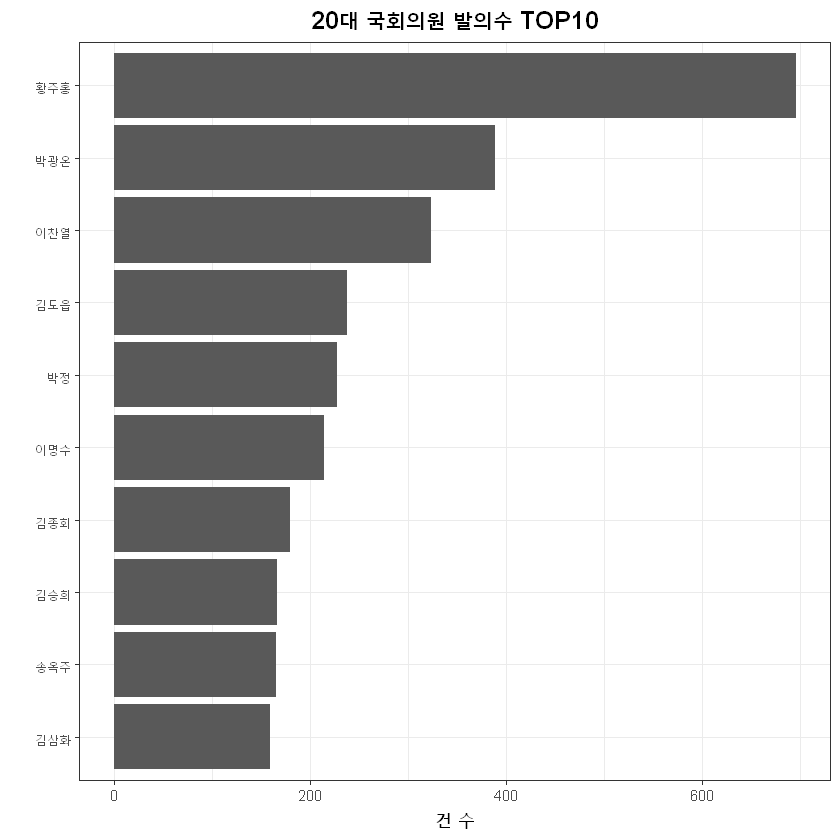

In [155]:
suggest_age20 %>%
  group_by(RST_PROPOSER) %>%
  summarise(n = n()) %>%
  arrange(desc(n)) %>%  head(10) %>%
  ggplot(aes(x = reorder(RST_PROPOSER, n), y = n)) +
  geom_bar(stat='identity') + 
  coord_flip() + theme_bw() +
  ggtitle("20대 국회의원 발의수 TOP10") +
  labs(x = "", y = "건 수") +
  theme(plot.title = element_text(size = 15, hjust = 0.5, face = 'bold'),
        axis.title = element_text(size = 13, face = 'bold'))

### 2.7.3 폐기,가결,대안반영만 추출

In [157]:
suggest_age20 %>%
  filter(PROC_RESULT == '임기만료폐기'|PROC_RESULT == '수정안반영폐기' | 
           PROC_RESULT == '수정가결' | PROC_RESULT == '원안가결' | PROC_RESULT == '대안반영폐기') %>%
  select(PROC_RESULT, RST_PROPOSER, PUBL_PROPOSER) -> age20_result_proposer

## 2.8. 20대 임기만료폐기, 대안방안, 가결(수정+원안) TOP10

`summarise()` ungrouping output (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)


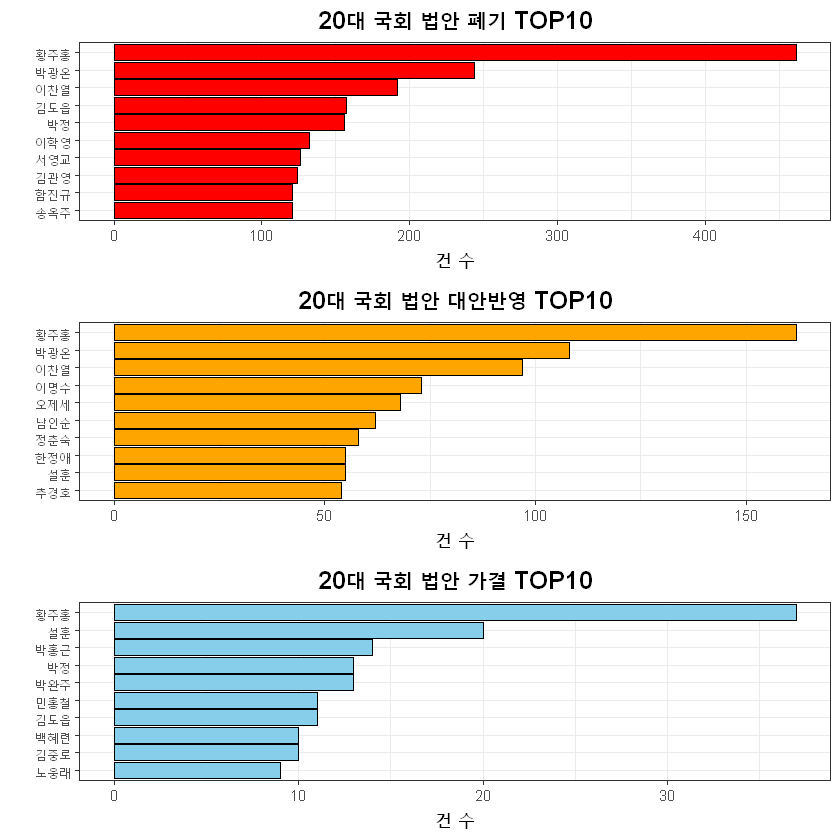

In [173]:
### 임기만료폐기만 추출
age20_result_proposer %>%
  filter(PROC_RESULT == '임기만료폐기' | PROC_RESULT == '수정안반영폐기') -> age20_trash_df
age20_trash_df %>%
  group_by(RST_PROPOSER) %>%
  summarise(임기만료폐기수 = n()) %>% 
  arrange(desc(임기만료폐기수)) %>%
  head(10) %>% 
  ggplot(aes(x = reorder(RST_PROPOSER, 임기만료폐기수), y = 임기만료폐기수)) +
  geom_bar(stat='identity', fill ='red', color = 'black') + 
  coord_flip() + theme_bw() +
  ggtitle("20대 국회 법안 폐기 TOP10") +
  labs(x = "", y = "건 수") +
  theme(plot.title = element_text(size = 15, hjust = 0.5, face = 'bold'),
        axis.title = element_text(size = 13, face = 'bold')) -> p1

### 대안반영만 추출
age20_result_proposer %>%
  filter(PROC_RESULT == '대안반영폐기') -> age20_alter_df
age20_alter_df %>%
  group_by(RST_PROPOSER) %>%
  summarise(n = n()) %>% 
  arrange(desc(n)) %>%
  head(10) %>% 
  ggplot(aes(x = reorder(RST_PROPOSER, n), y = n)) +
  geom_bar(stat='identity', fill = 'orange', color = 'black') + 
  coord_flip() + theme_bw() +
  ggtitle("20대 국회 법안 대안반영 TOP10") +
  labs(x = "", y = "건 수") +
  theme(plot.title = element_text(size = 15, hjust = 0.5, face = 'bold'),
        axis.title = element_text(size = 13, face = 'bold'))-> p2

### 가결(수정+원안)만 추출
age20_result_proposer %>%
  filter(PROC_RESULT == '수정가결'|PROC_RESULT == '원안') -> age20_success_df
age20_success_df %>%
  group_by(RST_PROPOSER) %>%
  summarise(n = n()) %>% 
  arrange(desc(n)) %>%
  head(10) %>% 
  ggplot(aes(x = reorder(RST_PROPOSER, n), y = n)) +
  geom_bar(stat='identity', fill = 'skyblue', color = 'black') +
  ggtitle("20대 국회 법안 가결 TOP10") +
  labs(x = "", y = "건 수") +
  coord_flip() + theme_bw() +
  theme(plot.title = element_text(size = 15, hjust = 0.5, face = 'bold'),
        axis.title = element_text(size = 13, face = 'bold'))-> p3

grid.arrange(p1,p2,p3)

+ ### 폐기와 대안반영은 황주홍, 박광온, 이찬열의원순으로 많지만 발의한 법안중 가결된 법안이 많은 의원은 황주홍, 설훈, 박홍근 순이다.
+ ### 황주홍은 발의한 법안이 많은 만큼 결과에서도 모두 다 높게 나타남.

## 2.9. 세가지 처리결과중 대안반영을 누가 많이 했고 누구와 같이 많이 했는가?
+ ### 세 가지 처리결과중 한가지만 대표로 시각화

+ ### 밑 코드는 젤 처음에 네트워크 시각화 전처리 코드와 비슷하므로 패스

In [174]:
#### 전체를 살펴보기엔 데이터가 크고 복잡해서 TOP5만 뽑아서 살펴봄
age20_alter_df %>%
  group_by(RST_PROPOSER) %>%
  summarise(n = n()) %>% 
  arrange(desc(n)) %>%
  head(5) -> alter_index

top5_alter_proposer <- age20_alter_df[age20_alter_df$RST_PROPOSER %in% alter_index$RST_PROPOSER,]
top5_alter_proposer %>%
  group_by(RST_PROPOSER) %>%
  summarise(n = n()) %>% arrange(desc(n))

age20_alter_split <- data.frame(RST_PROPOSER = top5_alter_proposer $RST_PROPOSER, 
                                   str_split(top5_alter_proposer $PUBL_PROPOSER, ",",  simplify = TRUE))
age20_alter_split[age20_alter_split == ""] <- NA

tmp <- data.frame()
test <- data.frame()
for(i in 1:dim(age20_alter_split)[1]){
  tmp <- data.frame()
  for(j in 2:dim(age20_alter_split)[2]){
    if(!is.na(age20_alter_split[i, j])){
      tmp[j-1, 1] = paste0(age20_alter_split[i, 1], ',', age20_alter_split[i, j])
    }
  }
  test <- rbind(test, tmp)
}
# View(test)
age20_alter_net <- test
alter_from_to <- data.frame(str_split(age20_alter_net$V1, ",",  simplify = TRUE))
colnames(alter_from_to) <- c('from','to')

alter_from_to %>%
  group_by(from, to) %>%
  summarise(n = n()) %>%
  arrange(desc(n)) -> alter_network

`summarise()` ungrouping output (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)


RST_PROPOSER,n
황주홍,162
박광온,108
이찬열,97
이명수,73
오제세,68


`summarise()` regrouping output by 'from' (override with `.groups` argument)


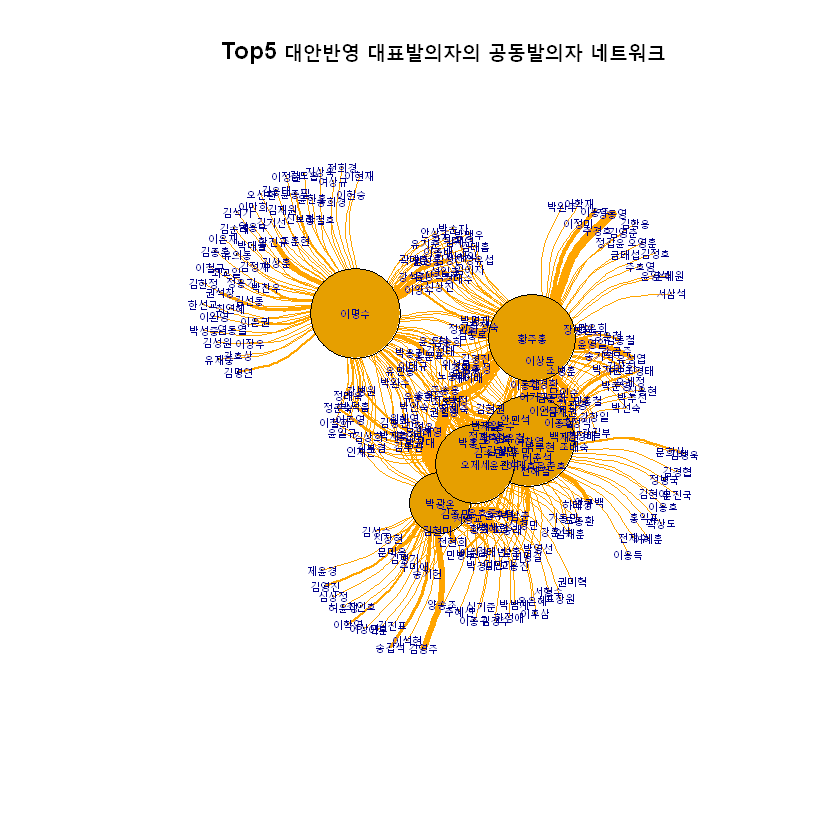

In [176]:
G <- graph_from_data_frame(alter_network, directed = FALSE);
l = layout_with_fr(G) # layout
plot(G,
     vertex.label.dist=0,
     vertex.shape='circle',
     vertex.size = igraph::degree(G, v =V(G), mode = 'all') / 3, #연결성중심으로 정점 크기 (조절필요)
     edge.width = E(G)$n / mean(E(G)$n), #조절할 필요가 있음
     edge.color="orange",
     edge.arrow.size=1,
     edge.curved=.3,
     vertex.label.cex = .5,
     main="Top5 대안반영 대표발의자의 공동발의자 네트워크",
     layout = l) 

+ ### 네트워크 시각화(network3D)

In [177]:
nodes <- data.frame(node = (V(G)$name)) 
size <- data.frame(size = igraph::degree(G, v =V(G), mode = 'all')); 
rownames(size) <- 1:dim(size)[1]
nodes <- bind_cols(nodes,size)
nodes$node <- factor(nodes$node, levels=nodes$node)
nodes$idx <- 1:dim(nodes)[1]

# 링크 데이터 생성
links <- data.frame(from = as.numeric(as.factor(alter_network$from))-1,
                    to = as.numeric(as.factor(alter_network$to))-1,
                    width = alter_network$n)
str(links)

# 시각화
forceNetwork(Nodes = nodes, Links = links,  Source = 'from', Target = 'to',
             NodeID = 'node', Group = 'node',
             zoom = TRUE, fontSize = 20,
             Nodesize = 'size',
             linkDistance = 200, 
             radiusCalculation = JS("d.nodesize + 30 "),
             Value = 'width', 
             linkWidth = JS("function(d) { return Math.sqrt(d.value); }"),
             opacity = 0.8, opacityNoHover = TRUE,
             charge=-900, fontFamily = 'NanumGothic Bold')

'data.frame':	502 obs. of  3 variables:
 $ from : num  4 0 3 0 0 4 4 4 3 0 ...
 $ to   : num  183 15 248 103 64 55 208 214 55 183 ...
 $ width: int  151 101 90 88 79 79 78 76 68 60 ...


HTML widgets cannot be represented in plain text (need html)

# 3. 각 의원마다 발의한 전체 법안의 처리결과와 가장 많이 발의한 TOP5 법안 관련 소관위와 소관위별 처리결과 시각화

## 3.1. 소관위별 관련 법안 시각화

### 3.1.1 소관위별 관련 법안 전체 발의수 시각화

`summarise()` ungrouping output (override with `.groups` argument)


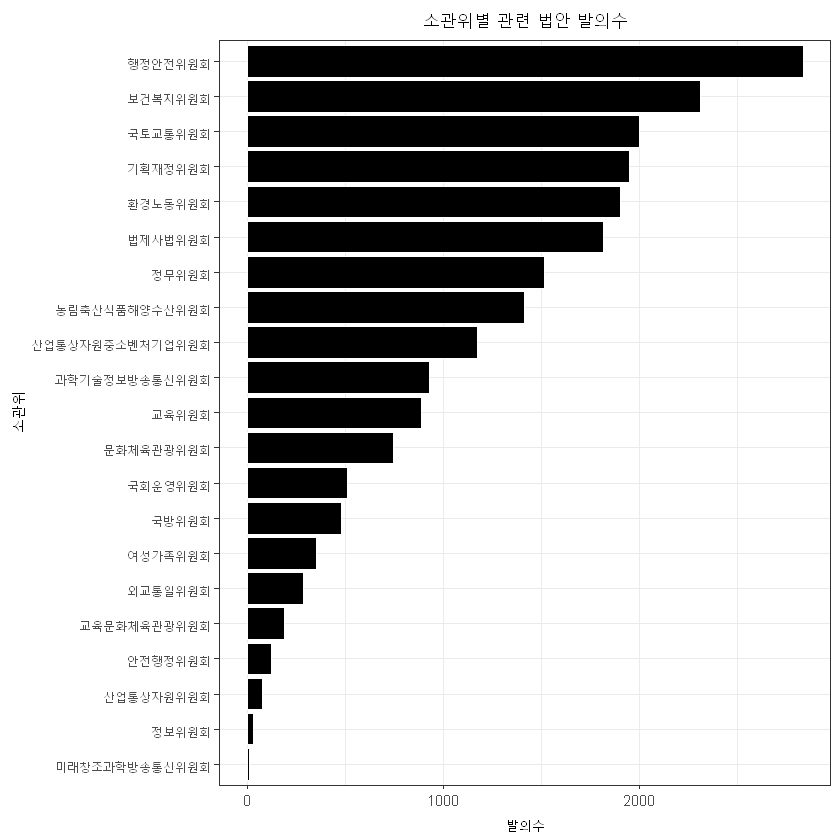

In [178]:
suggest_df <- suggest[-grep(suggest$COMMITTEE, pattern = "특별위원회"),]
age20_suggest <- suggest_df %>%
  filter(AGE == 20)
# 소관위원회별 발의된 수
age20_suggest %>%
  filter(!is.na(COMMITTEE)) %>%
  group_by(COMMITTEE) %>%
  summarise(n = n()) %>%
  arrange(desc(n)) %>%
  ggplot(aes(x = reorder(COMMITTEE, n), y= n)) +
  geom_bar(stat='identity', fill = 'black', color = 'white') +
  coord_flip() +
  theme_bw() +
  ggtitle("소관위별 관련 법안 발의수") +
  labs(x = "소관위", y = "발의수") +
  theme(plot.title = element_text(hjust = 0.5, size =13))

### 3.1.1 소관위별 관련 법안 처리결과 시각화

`summarise()` ungrouping output (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)


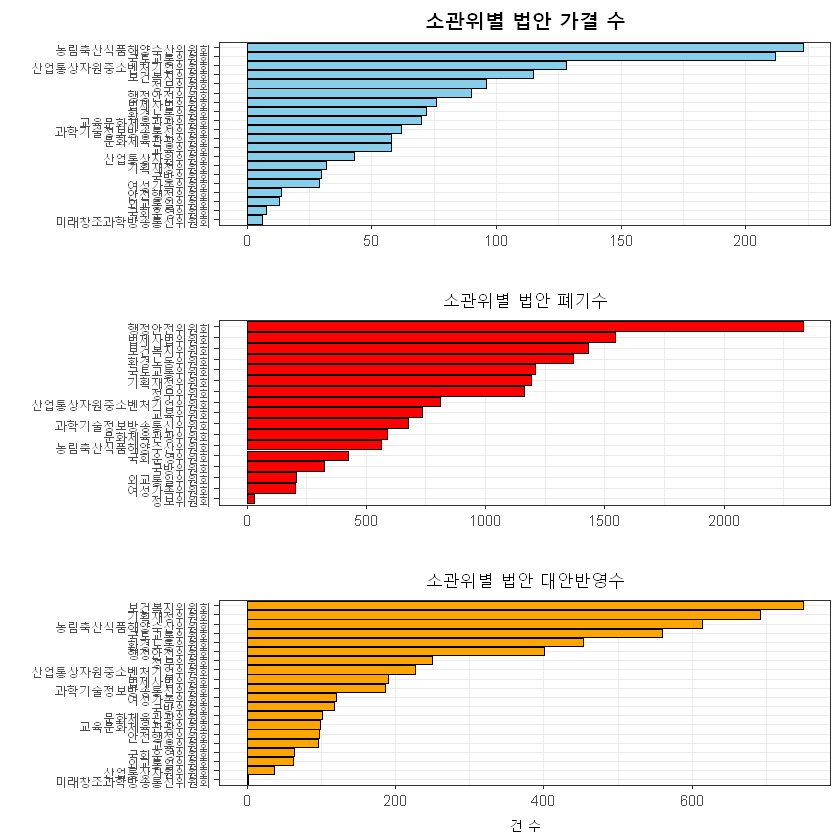

In [195]:
# 소관위별 가결
age20_suggest %>%
  filter(PROC_RESULT == '수정가결' | PROC_RESULT =='원안가결') %>%
  group_by(COMMITTEE) %>%
  summarise(n = n()) %>%
  ggplot(aes(x = reorder(COMMITTEE, n), y= n)) +
  geom_bar(stat='identity', fill = 'skyblue', color = 'black') +
  coord_flip() +
  theme_bw() +
  ggtitle("소관위별 법안 가결 수") +
  labs(x = "", y = "") +
  theme(plot.title = element_text(hjust = 0.5, size =15, face = 'bold')) -> p1

# 소관위별 폐기
age20_suggest %>%
  filter(!is.na(COMMITTEE)) %>%
  filter(PROC_RESULT == '임기만료폐기' | PROC_RESULT =='폐기' | PROC_RESULT == '수정안반영폐기') %>%
  group_by(COMMITTEE) %>%
  summarise(n = n()) %>%
  ggplot(aes(x = reorder(COMMITTEE, n), y= n)) +
  geom_bar(stat='identity', fill = 'red', color = 'black') +
  coord_flip() + theme_bw() +
  ggtitle("소관위별 법안 폐기수") +
  labs(x = "", y = "") +
  theme(plot.title = element_text(hjust = 0.5, size =13)) -> p2

# 소관위별 대안반영
age20_suggest %>%
  filter(!is.na(COMMITTEE)) %>%
  filter(PROC_RESULT == '대안반영폐기') %>%
  group_by(COMMITTEE) %>%
  summarise(n = n()) %>%
  ggplot(aes(x = reorder(COMMITTEE, n), y= n)) +
  geom_bar(stat='identity', fill = 'orange', color = 'black') +
  coord_flip() + theme_bw() +
  ggtitle("소관위별 법안 대안반영수") +
  labs(x = "", y = "건 수") +
  theme(plot.title = element_text(hjust = 0.5, size =13)) -> p3

grid.arrange(p1,p2,p3)

### 3.1.5 소관위별 처리결과(가결, 대안반영, 폐기) 비교

`summarise()` ungrouping output (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)
Joining, by = "COMMITTEE"
Joining, by = "COMMITTEE"


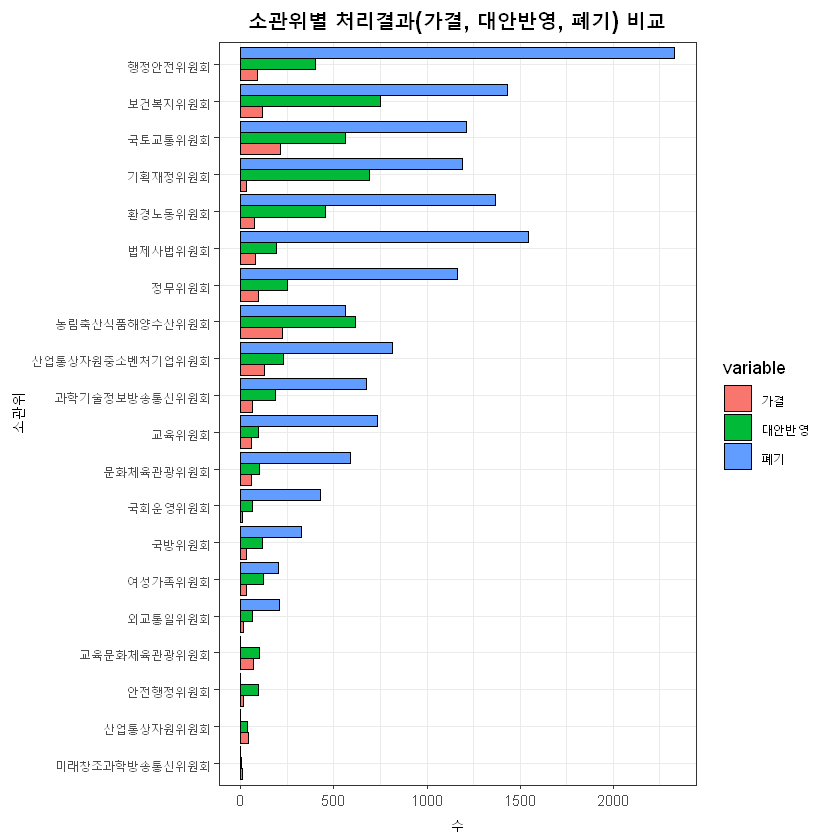

In [197]:
# 가결, 폐기, 대안반영 추출
age20_suggest %>%
  filter(!is.na(COMMITTEE)) %>% 
  filter(PROC_RESULT == '수정가결' | PROC_RESULT == '원안가결') %>%
  group_by(COMMITTEE) %>% 
  summarise(가결 = n()) -> success_df

age20_suggest %>%
  filter(!is.na(COMMITTEE)) %>% 
  filter(PROC_RESULT == '임기만료폐기' | PROC_RESULT == '수정안반영폐기' |
           PROC_RESULT == '폐기') %>%
  group_by(COMMITTEE) %>% 
  summarise(폐기= n()) -> trash_df

age20_suggest %>%
  filter(!is.na(COMMITTEE)) %>% 
  filter(PROC_RESULT == '대안반영폐기') %>%
  group_by(COMMITTEE) %>% 
  summarise(대안반영 = n()) -> alter_df

# 조인 및 처리결과별 비율
result_df <- left_join(inner_join(alter_df, success_df), trash_df)
result_df[is.na(result_df)] = 0 # NA를 0으로 처리
result_df %>%
  mutate(대안반영총합 = sum(대안반영),            # 각 처리결과 전체 합
               폐기총합 = sum(폐기),
               가결총합 = sum(가결)) %>%
  group_by(COMMITTEE) %>%
  mutate(대안반영율 = 대안반영 / 대안반영총합,    # 전체 중 각 처리 결과 비율
              폐기율 = 폐기 / 폐기총합,
              가결율 = 가결 / 가결총합) -> result_df

count_result_df <- melt(result_df, id.vars = "COMMITTEE", measure.vars = c("가결","대안반영","폐기"))
count_result_df %>%
  ggplot(aes(x = reorder(COMMITTEE, value), y = value, fill = variable)) +
  geom_bar(stat='identity', color = 'black', position = 'dodge') +
  coord_flip() +
  theme_bw() +
  ggtitle("소관위별 처리결과(가결, 대안반영, 폐기) 비교") +
  labs(x = "소관위", y = "수") +
  theme(plot.title = element_text(hjust = 0.5, size =15, face = 'bold'))

### 3.1.6 소관위별 처리결과(가결, 대안반영, 폐기) 비율 비교

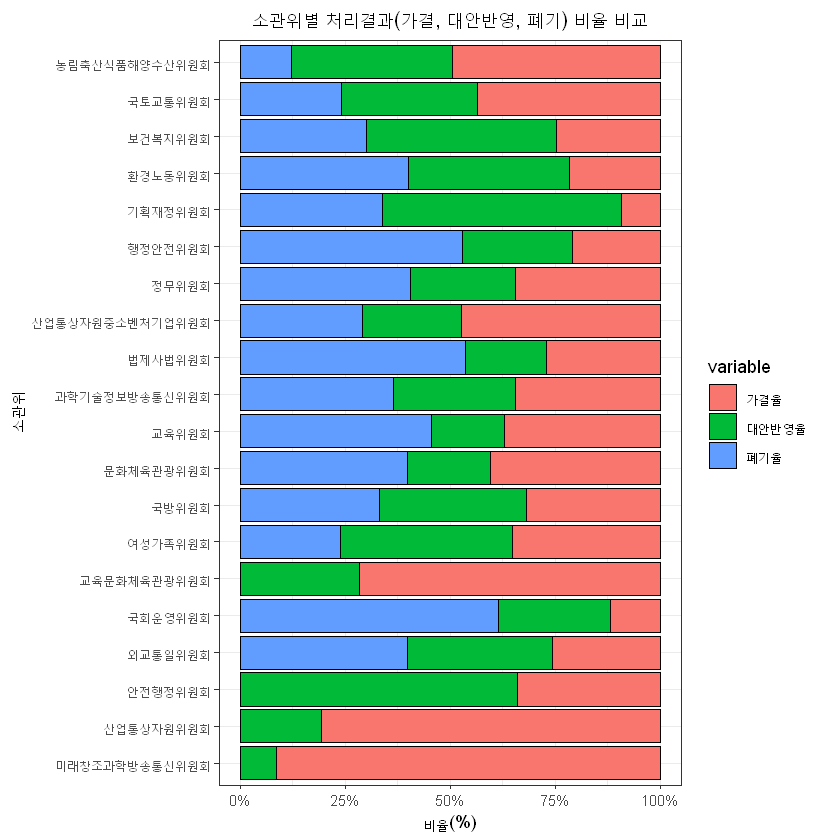

In [113]:
per_result_df <- melt(result_df, id.vars = "COMMITTEE", measure.vars = c("가결율","대안반영율","폐기율"))
per_result_df %>%
  mutate(COMMITTEE = factor(COMMITTEE)) %>%
  mutate(value = value * 100) %>%
  ggplot(aes(x = fct_reorder(COMMITTEE, value), y = value, fill = variable)) +
  geom_bar(stat='identity', position = 'fill', color = 'black') +
  coord_flip() +
  scale_y_continuous(labels = percent) +
  theme_bw() +
  ggtitle("소관위별 처리결과(가결, 대안반영, 폐기) 비율 비교") +
  labs(x = "소관위", y = "비율(%)") + theme(plot.title = element_text(hjust = 0.5, size =13))

## 3.2. 가장 많이 발의한 TOP5 법안 관련 소관위와 소관위별 처리결과 시각화

### 3.2.1 데이터 전처리
+ #### 20대의원 황주홍의원을 예시로 코드를 짰습니다 뒤에 함수화 시킵니다.

In [199]:
committee_df <- data.frame(COMMITTEE = levels(as.factor(age20_suggest$COMMITTEE)))
age20_suggest %>%
  filter(RST_PROPOSER == '황주홍') %>% #name
  filter(!is.na(COMMITTEE)) %>%
  group_by(RST_PROPOSER, COMMITTEE, PROC_RESULT) %>%
  summarise(n = n()) -> proposer_committee

proposer_committee_df <- full_join(proposer_committee,committee_df)
proposer_committee_df$RST_PROPOSER = '황주홍' #name
proposer_committee_df <- na.omit(proposer_committee_df)

proposer_committee_df %>%
  filter(PROC_RESULT == '수정가결' | PROC_RESULT == '원안가결') %>%
  group_by(COMMITTEE) %>%
  summarise(가결 = sum(n)) -> proposer_success_df
proposer_success_df <- left_join(committee_df, proposer_success_df )

proposer_committee_df %>%
  filter(PROC_RESULT == '임기만료폐기' | PROC_RESULT == '수정안반영폐기' | PROC_RESULT == '폐기') %>%
  group_by(COMMITTEE) %>%
  summarise(폐기 = sum(n)) -> proposer_trash_df
proposer_trash_df <- left_join(committee_df, proposer_trash_df )

proposer_committee_df %>%
  filter(PROC_RESULT == '대안반영폐기') %>%
  group_by(COMMITTEE) %>%
  summarise(대안반영 = sum(n)) -> proposer_alter_df
proposer_alter_df <- left_join(committee_df, proposer_alter_df )

proposer_committee_result <- inner_join(inner_join(proposer_success_df, proposer_trash_df, by ='COMMITTEE'), proposer_alter_df, by = 'COMMITTEE')
proposer_committee_result[is.na(proposer_committee_result)] = 0
head(proposer_committee)

`summarise()` regrouping output by 'RST_PROPOSER', 'COMMITTEE' (override with `.groups` argument)
Joining, by = "COMMITTEE"
`summarise()` ungrouping output (override with `.groups` argument)
Joining, by = "COMMITTEE"
`summarise()` ungrouping output (override with `.groups` argument)
Joining, by = "COMMITTEE"
`summarise()` ungrouping output (override with `.groups` argument)
Joining, by = "COMMITTEE"


RST_PROPOSER,COMMITTEE,PROC_RESULT,n
황주홍,과학기술정보방송통신위원회,대안반영폐기,7
황주홍,과학기술정보방송통신위원회,수정가결,3
황주홍,과학기술정보방송통신위원회,임기만료폐기,25
황주홍,과학기술정보방송통신위원회,폐기,3
황주홍,교육위원회,원안가결,1
황주홍,교육위원회,임기만료폐기,20


### 3.2.2 의원이 발의한 전체 법안 처리 결과율

`summarise()` ungrouping output (override with `.groups` argument)
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"윈도우즈 폰트데이터베이스에서 찾을 수 없는 폰트페밀리입니다"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"윈도우즈 폰트데이터베이스에서 찾을 수 없는 폰트페밀리입니다"

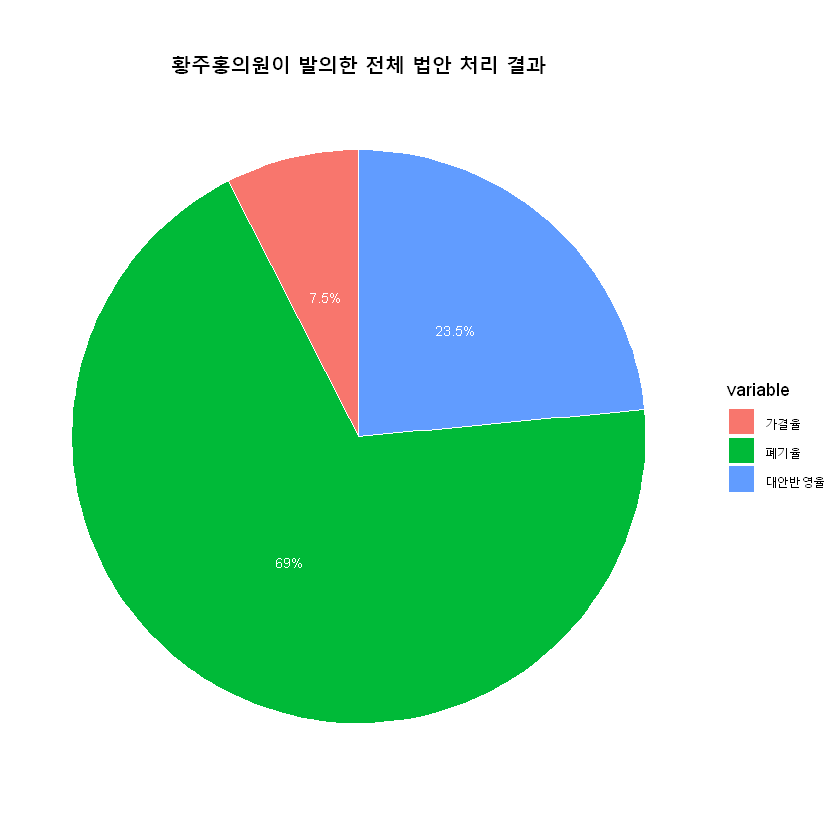

In [206]:
# 전체 비율을 구하기위한 변수
result_totalSum <- sum(proposer_committee_result$가결 + proposer_committee_result$폐기 + proposer_committee_result$대안반영)

proposer_committee_result %>%
  group_by(COMMITTEE) %>%
  mutate(가결율 = 가결 / result_totalSum,
            폐기율 = 폐기 / result_totalSum,
            대안반영율 = 대안반영 / result_totalSum) %>%
  melt(id.vars = 'COMMITTEE', measure.vars = c('가결율', '폐기율', '대안반영율')) -> melt_proposer_comm_result_ratio

melt_proposer_comm_result_ratio %>%
  group_by(variable) %>%
  summarise(비율 = round(sum(value) * 100, 1)) %>%
  ggplot(aes(x = "", y = 비율, fill = variable)) +
  geom_bar(stat='identity', width = 1, color = 'white') +
  coord_polar("y", start = 0) +
  theme_void() +
  ggtitle("황주홍의원이 발의한 전체 법안 처리 결과") +
  labs(x = "", y = "") +
  theme(plot.title = element_text(size = 15, hjust = 0.5, face = 'bold',family = "NanumGothic")) +
  geom_text(aes(label = paste0(비율, "%")),
            color = "white", size=3,position = position_stack(vjust = 0.5))

- ### 인터랙티브 시각화는 따로 돌려보세여 ㅠㅠ 

In [116]:
#proposer_committee_result %>%
#  group_by(COMMITTEE) %>%
#  melt(id.vars = 'COMMITTEE', measure.vars = c('가결', '폐기', '대안반영')) -> melt_proposer_comm_result_count
#melt_proposer_comm_result_count %>%
#  group_by(variable) %>%
#  summarise(value = sum(value)) %>% 
#  plot_ly(labels = ~variable, values = ~value, type = 'pie', 
#          textinfo='label+percent')%>%
#  layout(title = '황주홍의원, 발의한 전체 법안 처리 결과율',
#         xaxis = list(showgrid = FALSE, zeroline = FALSE, showticklabels = FALSE),
#         yaxis = list(showgrid = FALSE, zeroline = FALSE, showticklabels = FALSE))

### 3.2.3 의원이 발의한 법안 중 관련 TOP5 소관위별 처리결과

`summarise()` ungrouping output (override with `.groups` argument)
`summarise()` regrouping output by 'COMMITTEE' (override with `.groups` argument)
`summarise()` regrouping output by 'COMMITTEE' (override with `.groups` argument)
`summarise()` regrouping output by 'COMMITTEE' (override with `.groups` argument)
`summarise()` regrouping output by 'COMMITTEE' (override with `.groups` argument)
`summarise()` regrouping output by 'COMMITTEE' (override with `.groups` argument)


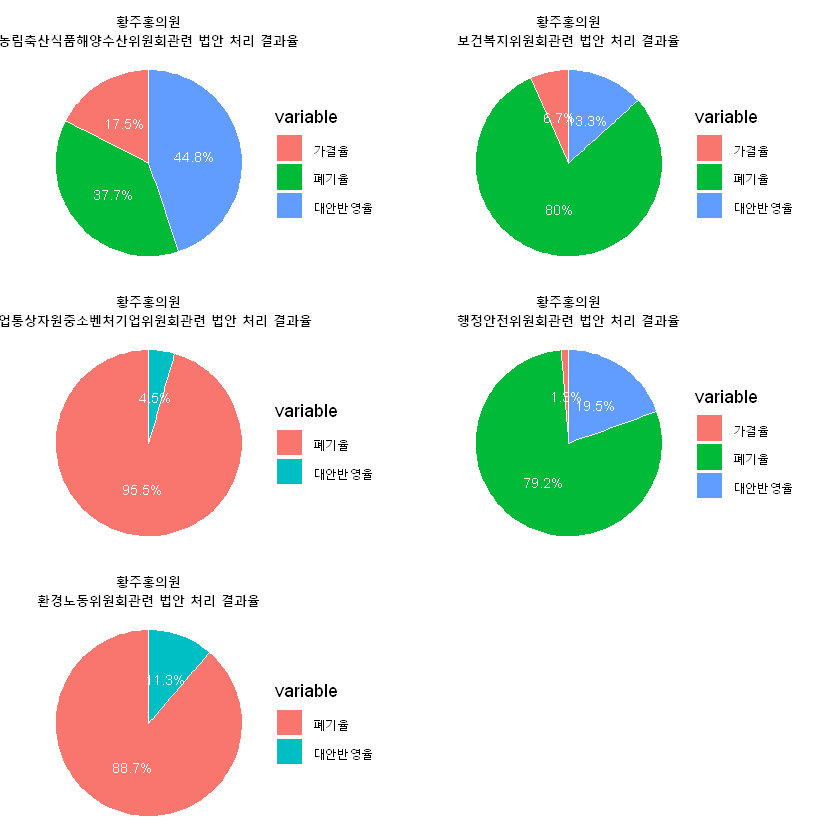

In [229]:
age20_suggest %>%
  filter(RST_PROPOSER =='황주홍') %>%
  group_by(COMMITTEE) %>%
  summarise(n = n()) %>%
  arrange(desc(n)) %>%
  head(5) -> top5_index

proposer_committee_result %>%
  filter(COMMITTEE %in% top5_index$COMMITTEE) %>%
  group_by(COMMITTEE) %>%
  mutate(가결율 = 가결 / sum(가결,폐기,대안반영),
            폐기율 = 폐기 / sum(가결,폐기,대안반영),
            대안반영율 = 대안반영 / sum(가결,폐기,대안반영)) -> proposer_committee_result_ratio
tmp <- list()
for(i in 1:5) {
  tmp[[i]] <- data.frame(melt(proposer_committee_result_ratio[i, ],
       id.vars = 'COMMITTEE', 
       measure.vars = c('가결율', '폐기율', '대안반영율')))
}

tmp[[1]] %>%
  group_by(COMMITTEE,variable) %>%
  summarise(비율 = round(sum(value) * 100, 1)) %>%
filter(비율 != 0) %>%
  ggplot(aes(x = "", y = 비율, fill = variable)) +
  geom_bar(stat='identity', width = 1, color = 'white') +
  coord_polar("y", start = 0) +
  theme_void() +
  ggtitle(paste0("황주홍의원\n",tmp[[1]]$COMMITTEE, "관련 법안 처리 결과율")) +
  labs(x = "", y = "") +
  theme(plot.title = element_text(size = 11, hjust = 0.5, face = 'bold')) +
  geom_text(aes(label = paste0(비율, "%")),
            color = "white", size=3, position = position_stack(vjust = 0.5)) -> p1 

tmp[[2]] %>%
  group_by(COMMITTEE,variable) %>%
  summarise(비율 = round(sum(value) * 100, 1)) %>%
filter(비율 != 0) %>%
  ggplot(aes(x = "", y = 비율, fill = variable)) +
  geom_bar(stat='identity', width = 1, color = 'white') +
  coord_polar("y", start = 0) +
  theme_void() +
  ggtitle(paste0("황주홍의원\n",tmp[[2]]$COMMITTEE, "관련 법안 처리 결과율")) +
  labs(x = "", y = "") +
  theme(plot.title = element_text(size = 11, hjust = 0.5,face = 'bold')) +
  geom_text(aes(label = paste0(비율, "%")),
            color = "white", size=3, position = position_stack(vjust = 0.5)) -> p2

tmp[[3]] %>%
  group_by(COMMITTEE,variable) %>%
  summarise(비율 = round(sum(value) * 100, 1)) %>%
filter(비율 != 0) %>%
  ggplot(aes(x = "", y = 비율, fill = variable)) +
  geom_bar(stat='identity', width = 1, color = 'white') +
  coord_polar("y", start = 0) +
  theme_void() +
  ggtitle(paste0("황주홍의원\n",tmp[[3]]$COMMITTEE, "관련 법안 처리 결과율")) +
  labs(x = "", y = "") +
  theme(plot.title = element_text(size = 11, hjust = 0.5, face = 'bold')) +
  geom_text(aes(label = paste0(비율, "%")),
            color = "white", size=3, position = position_stack(vjust = 0.5)) -> p3

tmp[[4]] %>%
  group_by(COMMITTEE,variable) %>%
  summarise(비율 = round(sum(value) * 100, 1)) %>%
filter(비율 != 0) %>%
  ggplot(aes(x = "", y = 비율, fill = variable)) +
  geom_bar(stat='identity', width = 1, color = 'white') +
  coord_polar("y", start = 0) +
  theme_void() +
  ggtitle(paste0("황주홍의원\n",tmp[[4]]$COMMITTEE, "관련 법안 처리 결과율")) +
  labs(x = "", y = "") +
  theme(plot.title = element_text(size = 11, hjust = 0.5, face = 'bold')) +
  geom_text(aes(label = paste0(비율, "%")),
            color = "white", size=3, position = position_stack(vjust = 0.5)) -> p4

tmp[[5]] %>%
  group_by(COMMITTEE,variable) %>%
  summarise(비율 = round(sum(value) * 100, 1)) %>%
  filter(비율 != 0) %>%
  ggplot(aes(x = "", y = 비율, fill = variable)) +
  geom_bar(stat='identity', width = 1, color = 'white') +
  coord_polar("y", start = 0) +
  theme_void() +
  ggtitle(paste0("황주홍의원\n",tmp[[5]]$COMMITTEE, "관련 법안 처리 결과율")) +
  labs(x = "", y = "") +
  theme(plot.title = element_text(size = 11, hjust = 0.5, face = 'bold')) +
  geom_text(aes(label = paste0(비율, "%")),
            color = "white", size=3, position = position_stack(vjust = 0.5)) -> p5


grid.arrange(p1,p2,p3,p4,p5, ncol = 2)

+ ### 황주홍의원은 농림축산해양수산 위원장으로 관련 법에 대해 많은 괌심을 가지고 있지만 가결율이 낮음. 다른 법안들은 폐기율이 상당히 높다

+ ### 인터랙티브 시각화는 따로 돌려보세여 ㅠㅠ (용량이 큽니다)

In [118]:
#melt_proposer_comm_result_count %>%
#  filter(COMMITTEE %in% top5_index$COMMITTEE) -> top5_result_df
#top5_result_df %>%
#  ggplot(aes(x = fct_reorder(COMMITTEE, value), y = value, fill = variable)) +
#  geom_bar(stat='identity', position = 'dodge', color = 'black') +
#  coord_flip()
#melt_proposer_comm_result_count %>%
#  filter(COMMITTEE %in% top5_index$COMMITTEE) -> top5_result_df
#top5_result_df %>%
#  ggplot(aes(x = fct_reorder(COMMITTEE, value), y = value, fill = variable)) +
#  geom_bar(stat='identity', position = 'dodge', color = 'black') +
#  coord_flip()
#fig <- plot_ly(textinfo = 'label + percent', 
#               textposition = 'inside',
#               insidetextfont = list(color = 'white'),
#               marker = list(line = list(color ='white', width = 1)))
#fig <- fig %>% add_pie(data = top5_result_df %>% filter(COMMITTEE == COMMITTEE[1]), 
#                       labels = ~variable, values = ~value, name = "", domain = list(row = 0, column = 0))
#fig <- fig %>% add_pie(data = top5_result_df %>% filter(COMMITTEE == COMMITTEE[2]), 
#                        labels = ~variable, values = ~value, name = "", domain = list(row = 0, column = 1))
#fig <- fig %>% add_pie(data = top5_result_df %>% filter(COMMITTEE == COMMITTEE[3]), 
#                       labels = ~variable, values = ~value, name = "", domain = list(row = 1, column = 0))
#fig <- fig %>% add_pie(data = top5_result_df %>% filter(COMMITTEE == COMMITTEE[4]), 
#                       labels = ~variable, values = ~value, name = "", domain = list(row = 1, column = 1))
#fig <- fig %>% add_pie(data = top5_result_df %>% filter(COMMITTEE == COMMITTEE[5]), 
#                       labels = ~variable, values = ~value, name = "", domain = list(row = 2, column = 0))
#fig <- fig %>% layout(title = "황주홍의원 발의한 법안관련 TOP5 소관위, 법안 처리결과", showlegend = T,
#                      grid=list(rows=3, columns=2),
#                      xaxis = list(showgrid = FALSE, zeroline = FALSE, showticklabels = FALSE),
#                      yaxis = list(showgrid = FALSE, zeroline = FALSE, showticklabels = FALSE))#

#fig

### 3.2.4 함수화

+ #### 20대 다른의원을 검색해보겠습니다.
+ #### 함수화는 인터랙티브시각화만 했습니다. 결과는 따로 돌려보시면 감사하겠습니다 (용량이 너무커요 ㅠㅠ)
+ #### 결과는 위 정적그래프와 똑같이 나오지만 좀 더 가시성이 좋습니다.

In [222]:
suggest %>% 
    filter(AGE == 20) %>%
    group_by(RST_PROPOSER) %>%
    summarise(n = n()) %>%
    arrange(desc(n)) %>% head(5)

top5_total <- function(age, name){
    # n대의원 추출, 특별위제외
  suggest_df <- suggest[-grep(suggest$COMMITTEE, pattern = "특별위원회"),]
  age_suggest <- suggest_df %>%
    filter(AGE == age)
  
  # 소관위원회 추출
  committee_df <- data.frame(COMMITTEE = levels(as.factor(age_suggest$COMMITTEE)))
  
  # 
  age_suggest %>%
    filter(RST_PROPOSER == name) %>% #name
    filter(!is.na(COMMITTEE)) %>%
    group_by(RST_PROPOSER, COMMITTEE, PROC_RESULT) %>%
    summarise(n = n()) -> proposer_committee
  
  # 소관위와 특정위원이 발의법안 관련 소관위를 조인
  proposer_committee_df <- full_join(proposer_committee,committee_df)
  proposer_committee_df$RST_PROPOSER = name #name
  na.omit(proposer_committee_df)
  
  # 법안 처리 가결건만 추출
  proposer_committee_df %>%
    filter(PROC_RESULT == '수정가결' | PROC_RESULT == '원안가결') %>%
    group_by(COMMITTEE) %>%
    summarise(가결 = sum(n)) -> proposer_success_df
  proposer_success_df <- left_join(committee_df, proposer_success_df )
  
  # 법안 처리 폐기건만 추출
  proposer_committee_df %>%
    filter(PROC_RESULT == '임기만료폐기' | PROC_RESULT == '수정안반영폐기' | PROC_RESULT == '폐기') %>%
    group_by(COMMITTEE) %>%
    summarise(폐기 = sum(n)) -> proposer_trash_df
  proposer_trash_df <- left_join(committee_df, proposer_trash_df )
  
  # 법안 처리 대안반영건만 추출
  proposer_committee_df %>%
    filter(PROC_RESULT == '대안반영폐기') %>%
    group_by(COMMITTEE) %>%
    summarise(대안반영 = sum(n)) -> proposer_alter_df
  proposer_alter_df <- left_join(committee_df, proposer_alter_df )
  
  # 법안 처리들을 모두 조인
  proposer_committee_result <- inner_join(inner_join(proposer_success_df, proposer_trash_df, by ='COMMITTEE'), proposer_alter_df, by = 'COMMITTEE')
  proposer_committee_result[is.na(proposer_committee_result)] = 0 # NA을 0으로 변경
  
  # 전처리 함수에서 받은 데이터를 시각화를 위해 metl시킴
  proposer_committee_result%>%
    group_by(COMMITTEE) %>%
    melt(id.vars = 'COMMITTEE', measure.vars = c('가결', '폐기', '대안반영')) -> melt_proposer_comm_result_count
    
  age_suggest %>%
    filter(RST_PROPOSER == name) %>%
    filter(!is.na(COMMITTEE)) %>%
    group_by(COMMITTEE) %>%
    summarise(n = n()) %>%
    arrange(desc(n)) %>%
    head(5) -> top5_index
    
  melt_proposer_comm_result_count %>%
    filter(COMMITTEE %in% top5_index$COMMITTEE) -> top5_result_df

  top5_result_df %>%
    ggplot(aes(x = fct_reorder(COMMITTEE, value), y = value, fill = variable)) +
    geom_bar(stat='identity', position = 'dodge', color = 'black') +
    coord_flip() +
    theme_bw() +
    ggtitle(paste0(name,"의원 발의 법안 관련TOP5 소관위별 처리결과")) + 
    theme(plot.title = element_text(hjust = 0.5, size =13)) +
    labs(x = "소관위", y = '수')-> p2
  return(p2)
}

`summarise()` ungrouping output (override with `.groups` argument)


RST_PROPOSER,n
황주홍,696
박광온,389
이찬열,324
김도읍,238
박정,228


In [223]:
#top5_total(20, '박광온')

In [224]:
each_proposer_total <- function(age, name) {
  # n대의원 추출, 특별위제외
  suggest_df <- suggest[-grep(suggest$COMMITTEE, pattern = "특별위원회"),]
  age_suggest <- suggest_df %>%
    filter(AGE == age)
  
  # 소관위원회 추출
  committee_df <- data.frame(COMMITTEE = levels(as.factor(age_suggest$COMMITTEE)))
  
  # 
  age_suggest %>%
    filter(RST_PROPOSER == name) %>% #name
    filter(!is.na(COMMITTEE)) %>%
    group_by(RST_PROPOSER, COMMITTEE, PROC_RESULT) %>%
    summarise(n = n()) -> proposer_committee
  
  # 소관위와 특정위원이 발의법안 관련 소관위를 조인
  proposer_committee_df <- full_join(proposer_committee,committee_df)
  proposer_committee_df$RST_PROPOSER = name #name
  na.omit(proposer_committee_df)
  
  # 법안 처리 가결건만 추출
  proposer_committee_df %>%
    filter(PROC_RESULT == '수정가결' | PROC_RESULT == '원안가결') %>%
    group_by(COMMITTEE) %>%
    summarise(가결 = sum(n)) -> proposer_success_df
  proposer_success_df <- left_join(committee_df, proposer_success_df )
  
  # 법안 처리 폐기건만 추출
  proposer_committee_df %>%
    filter(PROC_RESULT == '임기만료폐기' | PROC_RESULT == '수정안반영폐기' | PROC_RESULT == '폐기') %>%
    group_by(COMMITTEE) %>%
    summarise(폐기 = sum(n)) -> proposer_trash_df
  proposer_trash_df <- left_join(committee_df, proposer_trash_df )
  
  # 법안 처리 대안반영건만 추출
  proposer_committee_df %>%
    filter(PROC_RESULT == '대안반영폐기') %>%
    group_by(COMMITTEE) %>%
    summarise(대안반영 = sum(n)) -> proposer_alter_df
  proposer_alter_df <- left_join(committee_df, proposer_alter_df )
  
  # 법안 처리들을 모두 조인
  proposer_committee_result <- inner_join(inner_join(proposer_success_df, proposer_trash_df, by ='COMMITTEE'), proposer_alter_df, by = 'COMMITTEE')
  proposer_committee_result[is.na(proposer_committee_result)] = 0 # NA을 0으로 변경
  
  # 전처리 함수에서 받은 데이터를 시각화를 위해 metl시킴
  proposer_committee_result%>%
    group_by(COMMITTEE) %>%
    melt(id.vars = 'COMMITTEE', measure.vars = c('가결', '폐기', '대안반영')) -> melt_proposer_comm_result_count
  
    #전체 발의 시각화
  melt_proposer_comm_result_count %>%
    group_by(variable) %>%
    summarise(value = sum(value)) %>% 
    plot_ly(labels = ~variable, values = ~value, type = 'pie', 
            textinfo='label+percent')%>%
    layout(title = paste0(name, '의원이 발의한 법안 전체 처리 결과율'),
           xaxis = list(showgrid = FALSE, zeroline = FALSE, showticklabels = FALSE),
           yaxis = list(showgrid = FALSE, zeroline = FALSE, showticklabels = FALSE)) -> p1
    p1
    return(p1)
}

In [225]:
#each_proposer_total(20, '박광온')

In [226]:
top5_committee <- function(age,name) {
    # n대의원 추출, 특별위제외
  suggest_df <- suggest[-grep(suggest$COMMITTEE, pattern = "특별위원회"),]
  age_suggest <- suggest_df %>%
    filter(AGE == age)
  
  # 소관위원회 추출
  committee_df <- data.frame(COMMITTEE = levels(as.factor(age_suggest$COMMITTEE)))
  
  # 
  age_suggest %>%
    filter(RST_PROPOSER == name) %>% #name
    filter(!is.na(COMMITTEE)) %>%
    group_by(RST_PROPOSER, COMMITTEE, PROC_RESULT) %>%
    summarise(n = n()) -> proposer_committee
  
  # 소관위와 특정위원이 발의법안 관련 소관위를 조인
  proposer_committee_df <- full_join(proposer_committee,committee_df)
  proposer_committee_df$RST_PROPOSER = name #name
  na.omit(proposer_committee_df)
  
  # 법안 처리 가결건만 추출
  proposer_committee_df %>%
    filter(PROC_RESULT == '수정가결' | PROC_RESULT == '원안가결') %>%
    group_by(COMMITTEE) %>%
    summarise(가결 = sum(n)) -> proposer_success_df
  proposer_success_df <- left_join(committee_df, proposer_success_df )
  
  # 법안 처리 폐기건만 추출
  proposer_committee_df %>%
    filter(PROC_RESULT == '임기만료폐기' | PROC_RESULT == '수정안반영폐기' | PROC_RESULT == '폐기') %>%
    group_by(COMMITTEE) %>%
    summarise(폐기 = sum(n)) -> proposer_trash_df
  proposer_trash_df <- left_join(committee_df, proposer_trash_df )
  
  # 법안 처리 대안반영건만 추출
  proposer_committee_df %>%
    filter(PROC_RESULT == '대안반영폐기') %>%
    group_by(COMMITTEE) %>%
    summarise(대안반영 = sum(n)) -> proposer_alter_df
  proposer_alter_df <- left_join(committee_df, proposer_alter_df )
  
  # 법안 처리들을 모두 조인
  proposer_committee_result <- inner_join(inner_join(proposer_success_df, proposer_trash_df, by ='COMMITTEE'), proposer_alter_df, by = 'COMMITTEE')
  proposer_committee_result[is.na(proposer_committee_result)] = 0 # NA을 0으로 변경
  
  # 전처리 함수에서 받은 데이터를 시각화를 위해 metl시킴
  proposer_committee_result%>%
    group_by(COMMITTEE) %>%
    melt(id.vars = 'COMMITTEE', measure.vars = c('가결', '폐기', '대안반영')) -> melt_proposer_comm_result_count
  
  # 의원 발의법안 관련 top5 소관위 추출
  age20_suggest %>%
    filter(RST_PROPOSER == name) %>%
    group_by(COMMITTEE) %>%
    summarise(n = n()) %>%
    arrange(desc(n)) %>%
    head(5) -> top5_index
  
  # 시각화를 위해 melt
  melt_proposer_comm_result_count %>%
    filter(COMMITTEE %in% top5_index$COMMITTEE) -> top5_result_df
  
  # 소관위 TOP5 인터랙티브 시각화 
  fig <- plot_ly(textinfo = 'label + percent', 
                 textposition = 'inside',
                 insidetextfont = list(color = 'white'),
                 marker = list(line = list(color ='white', width = 1)))
  fig <- fig %>% add_pie(data = top5_result_df %>% filter(COMMITTEE == COMMITTEE[1]), 
                         labels = ~variable, values = ~value, name = "", domain = list(row = 0, column = 0))
  fig <- fig %>% add_pie(data = top5_result_df %>% filter(COMMITTEE == COMMITTEE[2]), 
                         labels = ~variable, values = ~value, name = "", domain = list(row = 0, column = 1))
  fig <- fig %>% add_pie(data = top5_result_df %>% filter(COMMITTEE == COMMITTEE[3]), 
                         labels = ~variable, values = ~value, name = "", domain = list(row = 1, column = 0))
  fig <- fig %>% add_pie(data = top5_result_df %>% filter(COMMITTEE == COMMITTEE[4]), 
                         labels = ~variable, values = ~value, name = "", domain = list(row = 1, column = 1))
  fig <- fig %>% add_pie(data = top5_result_df %>% filter(COMMITTEE == COMMITTEE[5]), 
                         labels = ~variable, values = ~value, name = "", domain = list(row = 2, column = 0))
  fig <- fig %>% layout(title = paste0(name,"의원 발의한 법안관련 TOP5 소관위별 법안 처리결과"), 
                        showlegend = T,
                        grid=list(rows=3, columns=2),
                        xaxis = list(showgrid = FALSE, zeroline = FALSE, showticklabels = FALSE),
                        yaxis = list(showgrid = FALSE, zeroline = FALSE, showticklabels = FALSE))
  return(fig)
}

In [124]:
#top5_committee(20, '박광온')

## 결론: 
+ ### 대표발의자와 공동발의자에 네트워크 시각화를 통해 어떤 의원끼리 발의를 많이하고 관련이 있는지 파악 가능
+ ### 각 의원마다 어떤 법안에 관심을 가지고 있으며, 각 처리된 결과를 보여줌으로 의원들이 얼마나 각 법안에 대해 심혈을 기울이는지 살펴볼 수 있있다.
+ ### 대안반영과 폐기가 많을 수록 있는 법안을 갖다 붙이는 법도 많으며, 법안만 발의하고 관심을 주지 않을 가능성이 높다. 
+ ### 영양가 없는 법안을 내놓으면서 보여주기식 입법활동이 많을 가능성이 있음